In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

import gbd_mapping as gm
from vivarium import Artifact

# from db_queries import get_ids, get_outputs, get_population, get_covariate_estimates
# from get_draws.api import get_draws

!date
!whoami
!pwd

Wed Feb  4 16:43:19 PST 2026
ndbs
/Users/ndbs/repos/vivarium_research_alzheimers/verification_and_validation


# V&V List from Docs

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

### Note: This notebook currently only shows results for the baseline scenario.

# Load Data

Results: 

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/model11.1/model_spec/2026_01_31_09_07_34

Artifact:

/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0

In [2]:
if os.sys.platform == 'darwin':
    # Notebook is running on Nathaniel's MacBook
    project_directory = "/Users/ndbs/project_data/vivarium_csu_alzheimers/"
else:
    # Assume we're running on the cluster
    project_directory = '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/'

In [3]:
%cd $project_directory

/Users/ndbs/project_data/vivarium_csu_alzheimers


In [4]:
locations = [
            'united_states_of_america',
             'brazil',
             'china',
            #  'germany',
            #  'israel',
            #  'japan',
            #  'spain',
            #  'sweden',
            #  'taiwan_(province_of_china)',
            #  'united_kingdom',
            ]



results_dirs = [
    # 'results/abie_consistent_model_test/china/2026_01_11_13_36_17/results/',
    'results/model11.1/model_spec/2026_01_31_09_07_34/results/',
]

artifact_subdirs = ['artifacts/model10.0/' + x + '.hdf' for x in locations]
# Local paths to artifacts, which may be on laptop or cluster
artifact_dirs = [project_directory + artifact_subdir
                 for artifact_subdir in artifact_subdirs]
# Paths to artifacts on cluster, used for mapping locations in results dataframes
cluster_artifact_dirs = ['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/' + artifact_subdir
                 for artifact_subdir in artifact_subdirs]
# artifact_dirs = ['/ihme/homes/abie/projects/2025/vivarium_csu_alzheimers/china.hdf']
artifact_dirs

['/Users/ndbs/project_data/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
 '/Users/ndbs/project_data/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf',
 '/Users/ndbs/project_data/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf']

In [5]:
apath = artifact_dirs[0]
# apath = project_directory + artifact_subdirs[0]
!ls $apath

/Users/ndbs/project_data/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf


In [6]:
# .parquet files are now in subfolders...
[x for x in os.listdir(results_dirs[0]) ]#if 'parquet' in x]

['counts_bbbm_tests',
 'counts_baseline_tests_among_eligible',
 'deaths',
 'counts_newly_eligible_for_bbbm_testing',
 'transition_count_alzheimers_disease_and_other_dementias',
 'ylds',
 'ylls',
 'treatment_duration',
 'person_time_alzheimers_disease_and_other_dementias',
 'person_time_treatment',
 'counts_new_simulants',
 'person_time_eligible_for_bbbm_testing',
 'person_time_ever_eligible_for_bbbm_testing',
 'transition_count_treatment']

In [7]:
art = Artifact(apath)

# age_bins is an empty DataFrame with a MultiIndex storing age group data
age_bins = art.load('population.age_bins')
age_dictionary = (
    age_bins
    .reset_index()
    .assign(age_group=lambda df: df['age_group_name'].str.replace(' ', '_'))
    # Filter to ages that actually appear in our sim
    .query("age_start >= 25")
)
age_dictionary

age_group_id age_group_name  age_start  age_end age_group
4             10       25 to 29       25.0     30.0  25_to_29
5             11       30 to 34       30.0     35.0  30_to_34
6             12       35 to 39       35.0     40.0  35_to_39
7             13       40 to 44       40.0     45.0  40_to_44
8             14       45 to 49       45.0     50.0  45_to_49
9             15       50 to 54       50.0     55.0  50_to_54
10            16       55 to 59       55.0     60.0  55_to_59
11            17       60 to 64       60.0     65.0  60_to_64
12            18       65 to 69       65.0     70.0  65_to_69
13            19       70 to 74       70.0     75.0  70_to_74
14            20       75 to 79       75.0     80.0  75_to_79
15            30       80 to 84       80.0     85.0  80_to_84
16            31       85 to 89       85.0     90.0  85_to_89
17            32       90 to 94       90.0     95.0  90_to_94
18           235        95 plus       95.0    125.0   95_plus

In [ ]:
## Old version of generating age_dictionary, requiring get_ids

# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

## Verify that all simulants in the model have AD 

In [9]:
# filters = [('artifact_path', '==', cluster_artifact_dirs[0])]
filters=None
test = pd.read_parquet(results_dirs[0] + 'deaths', filters=filters)
# test['location'] = locations[0]
print(test.memory_usage(deep=True).sum() / 1e6)
test#.artifact_path.unique()

1150.644503


measure entity_type                    entity  \
0        deaths       cause  alzheimers_disease_state   
1        deaths       cause  alzheimers_disease_state   
2        deaths       cause  alzheimers_disease_state   
3        deaths       cause  alzheimers_disease_state   
4        deaths       cause  alzheimers_disease_state   
...         ...         ...                       ...   
3554995  deaths       cause              other_causes   
3554996  deaths       cause              other_causes   
3554997  deaths       cause              other_causes   
3554998  deaths       cause              other_causes   
3554999  deaths       cause              other_causes   

                       sub_entity age_group event_year     sex  \
0        alzheimers_disease_state  25_to_29       2022  Female   
1        alzheimers_disease_state  25_to_29       2022    Male   
2        alzheimers_disease_state  25_to_29       2023  Female   
3        alzheimers_disease_state  25_to_29       2023    Male   
4        alzheimers_disease_state  25_to_29       2024  Female   
...                           ...       ...        ...     ...   
3554995              other_causes   95_plus       2098    Male   
3554996              other_causes   95_plus       2099  Female   
3554997              other_causes   95_plus       2099    Male   
3554998              other_causes   95_plus       2100  Female   
3554999              other_causes   95_plus       2100    Male   

                                             artifact_path  scenario  \
0        /mnt/team/simulation_science/pub/models/vivari...  baseline   
1        /mnt/team/simulation_science/pub/models/vivari...  baseline   
2        /mnt/team/simulation_science/pub/models/vivari...  baseline   
3        /mnt/team/simulation_science/pub/models/vivari...  baseline   
4        /mnt/team/simulation_science/pub/models/vivari...  baseline   
...                                                    ...       ...   
3554995  /mnt/team/simulation_science/pub/models/vivari...  baseline   
3554996  /mnt/team/simulation_science/pub/models/vivari...  baseline   
3554997  /mnt/team/simulation_science/pub/models/vivari...  baseline   
3554998  /mnt/team/simulation_science/pub/models/vivari...  baseline   
3554999  /mnt/team/simulation_science/pub/models/vivari...  baseline   

         input_draw  random_seed  value  
0               211         2787    0.0  
1               211         2787    0.0  
2               211         2787    0.0  
3               211         2787    0.0  
4               211         2787    0.0  
...             ...          ...    ...  
3554995          63         2787   58.0  
3554996          63         2787  590.0  
3554997          63         2787   60.0  
3554998          63         2787  547.0  
3554999          63         2787   56.0  

[3555000 rows x 12 columns]

In [10]:
test.random_seed.nunique()

5

In [11]:
test.input_draw.nunique()

25

In [12]:
test.artifact_path.unique()

array(['/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf',
       '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf',
       '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf'],
      dtype=object)

In [13]:
[[('artifact_path', '==', artifact_dir)]
                 for artifact_dir in cluster_artifact_dirs
                 ]

[[('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/united_states_of_america.hdf')],
 [('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/brazil.hdf')],
 [('artifact_path',
   '==',
   '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model10.0/china.hdf')]]

In [14]:
# # Model 10.0 was run with 100 seeds instead of 5, so let's just filter
# # everything to 5 seeds to make it all run faster
# # seeds = [338, 6520, 3585, 7745, 539]
# seeds = [7179, 2599, 1534, 386, 1935]
# seed_filter = ('random_seed', 'in', seeds)

def print_memory_usage(df, label=''):
    """Print the memory usage of a dataframe in megabytes."""
    print(df.memory_usage(deep=True).sum() / 1e6, 'MB', label)

def convert_to_categorical(
        df,
        include_cols=(),
        exclude_cols=(),
        exclude_dtypes=('float', 'category'),
        inplace=False
    ):
    """Convert all columns except float columns to categorical. This
    saves lots of memory, allowing us to load and manipulate larger
    DataFrames.
    """
    if  len(set(include_cols).intersection(exclude_cols)) != 0:
        raise ValueError("A column can't be both included and excluded!")
    if not inplace:
        df = df.copy()
    for col in df:
        if (
            col in include_cols
            or (col not in exclude_cols 
                and df[col].dtype not in exclude_dtypes)
        ):
            df[col] = df[col].astype('category')
    if not inplace:
        return df
    else:
        return None

def load_df(measure):
    # data = pd.DataFrame()
    dfs_by_location = []
    data_all = pd.read_parquet(
        # NOTE: .parquet files are in subfolders after Vivarium update
        results_dirs[0] + measure, #+ '.parquet',
        # # Filter random seeds
        # filters = [seed_filter],
        # # Combine location filters with OR using disjunctive normal form
        # filters=[[('artifact_path', '==', artifact_dir)]
        #          for artifact_dir in cluster_artifact_dirs
        #          ],
    )
    print_memory_usage(data_all, 'for parquet file loaded into memory')
    convert_to_categorical(data_all, inplace=True)
    print_memory_usage(data_all, 'after converting to categorical')
    # Loop through unique locations (artifact paths), and aggregate
    # random seeds for each one, then concatenate
    for location, artifact in zip(locations, cluster_artifact_dirs):
        temp = data_all[data_all.artifact_path == artifact]

        # aggregate by summing value column over random seeds
        cols = [c for c in temp.columns if c not in ['value', 'random_seed']]
        temp = temp.groupby(cols, observed=True)['value'].sum().reset_index()
        
        temp['location'] = location
        # temp['location'] = locations[results_dirs.index(results_dir)].title()
        temp['event_year'] = temp['event_year'].astype(int)
        # data = pd.concat([data, temp], ignore_index=True)
        dfs_by_location.append(temp)
    data = pd.concat(dfs_by_location, ignore_index=True)
    print_memory_usage(data, 'after aggregating seeds')
    convert_to_categorical(data, exclude_cols=['event_year'], inplace=True)
    print_memory_usage(data, 'after converting aggregated data to categoricals')
    return data

In [15]:
person_time = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time
# person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum()

15506.919836 MB for parquet file loaded into memory
639.912187 MB after converting to categorical
605.777052 MB after aggregating seeds
172.778366 MB after converting aggregated data to categoricals


measure entity_type                                  entity  \
0        person_time       cause  alzheimers_disease_and_other_dementias   
1        person_time       cause  alzheimers_disease_and_other_dementias   
2        person_time       cause  alzheimers_disease_and_other_dementias   
3        person_time       cause  alzheimers_disease_and_other_dementias   
4        person_time       cause  alzheimers_disease_and_other_dementias   
...              ...         ...                                     ...   
6398995  person_time       cause  alzheimers_disease_and_other_dementias   
6398996  person_time       cause  alzheimers_disease_and_other_dementias   
6398997  person_time       cause  alzheimers_disease_and_other_dementias   
6398998  person_time       cause  alzheimers_disease_and_other_dementias   
6398999  person_time       cause  alzheimers_disease_and_other_dementias   

                                         sub_entity age_group  event_year  \
0            alzheimers_blood_based_biomarker_state  25_to_29        2022   
1            alzheimers_blood_based_biomarker_state  25_to_29        2022   
2            alzheimers_blood_based_biomarker_state  25_to_29        2022   
3            alzheimers_blood_based_biomarker_state  25_to_29        2022   
4            alzheimers_blood_based_biomarker_state  25_to_29        2022   
...                                             ...       ...         ...   
6398995  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398996  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398997  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398998  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398999  alzheimers_mild_cognitive_impairment_state   95_plus        2100   

            sex                  treatment  \
0        Female  no_effect_after_treatment   
1        Female  no_effect_after_treatment   
2        Female  no_effect_after_treatment   
3        Female  no_effect_after_treatment   
4        Female  no_effect_after_treatment   
...         ...                        ...   
6398995    Male              waning_effect   
6398996    Male              waning_effect   
6398997    Male              waning_effect   
6398998    Male              waning_effect   
6398999    Male              waning_effect   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
6398995  /mnt/team/simulation_science/pub/models/vivari...   
6398996  /mnt/team/simulation_science/pub/models/vivari...   
6398997  /mnt/team/simulation_science/pub/models/vivari...   
6398998  /mnt/team/simulation_science/pub/models/vivari...   
6398999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario input_draw     value  \
0                          baseline          1  0.000000   
1                          baseline          6  0.000000   
2                          baseline          7  0.000000   
3                          baseline         24  0.000000   
4                          baseline         35  0.000000   
...                             ...        ...       ...   
6398995  bbbm_testing_and_treatment        235  5.979466   
6398996  bbbm_testing_and_treatment        236  2.989733   
6398997  bbbm_testing_and_treatment        245  1.993155   
6398998  bbbm_testing_and_treatment        248  0.996578   
6398999  bbbm_testing_and_treatment        249  5.481177   

                         location  
0        united_states_of_america  
1        united_states_of_america  
2        united_states_of_america  
3        uni

In [16]:
person_time.treatment.unique()

['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']
Categories (6, object): ['no_effect_after_treatment', 'no_effect_never_treated', 'susceptible_to_treatment', 'treatment_effect', 'waiting_for_treatment', 'waning_effect']

In [17]:
person_time.query("location=='china'").artifact_path.nunique()

1

In [18]:
person_time.location.unique()

['united_states_of_america', 'brazil', 'china']
Categories (3, object): ['brazil', 'china', 'united_states_of_america']

In [19]:
person_time.memory_usage(deep=True)

Index                 132
measure           6399176
entity_type       6399170
entity            6399203
sub_entity        6399383
age_group         6400530
event_year       51192000
sex               6399232
treatment         6399636
artifact_path     6399578
scenario          6399256
input_draw        6399756
value            51192000
location          6399314
dtype: int64

In [20]:
person_time.dtypes

measure          category
entity_type      category
entity           category
sub_entity       category
age_group        category
event_year          int64
sex              category
treatment        category
artifact_path    category
scenario         category
input_draw       category
value             float64
location         category
dtype: object

In [21]:
# This is insane -- 45 GB!
print_memory_usage(person_time)

172.778366 MB 


In [22]:
assert person_time.loc[person_time.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero years of person-time susceptible'

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [23]:
person_time.groupby('sub_entity').value.sum()

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1434696413.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby('sub_entity').value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        1.481954e+09
alzheimers_disease_state                      1.026917e+09
alzheimers_mild_cognitive_impairment_state    6.610461e+08
Name: value, dtype: float64

In [24]:
person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/63004212.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
brazil                   2022       25_to_29                             0.000000e+00   
                                    30_to_34                             0.000000e+00   
                                    35_to_39                             3.986311e+00   
                                    40_to_44                             4.394908e+03   
                                    45_to_49                             2.852903e+04   
...                                                                               ...   
united_states_of_america 2100       75_to_79                             9.914179e+05   
                                    80_to_84                             1.038392e+06   
                                    85_to_89                             8.758124e+05   
                                    90_to_94                             4.485427e+05   
                                    95_plus                              1.336406e+05   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
brazil                   2022       25_to_29                   0.000000   
                                    30_to_34                   0.000000   
                                    35_to_39                   0.000000   
                                    40_to_44                  36.873374   
                                    45_to_49                5438.324435   
...                                                                 ...   
united_states_of_america 2100       75_to_79              551960.032854   
                                    80_to_84              751350.811773   
                                    85_to_89              742299.394935   
                                    90_to_94              499645.683778   
                                    95_plus               220935.293634   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
brazil                   2022       25_to_29                                     0.000000  
                                    30_to_34                                     0.000000  
                                    35_to_39                                     1.993155  
                                    40_to_44                                   715.542779  
                                    45_to_49                                  8517.749487  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                408846.494182  
                                    80_to_84                                463191.868583  
                                    85_to_89                                449622.965092  
                                    90_to_94                                272050.261465  
                                    95_plus                                 105906.310746  

[3555 rows x 3 columns]

In [25]:
#assert np.all(person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [26]:
trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum()

10444.599829 MB for parquet file loaded into memory
426.612185 MB after converting to categorical
403.85305 MB after aggregating seeds
115.187364 MB after converting aggregated data to categoricals


0.0

In [27]:
assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
       'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [28]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [29]:
out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
out_counts.columns = [c.split('_to_')[0] for c in out_counts.columns]
#out_counts

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1392242333.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_counts = trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


In [30]:
out_counts

alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
brazil                   2022       25_to_29                                      0.0   
                                    30_to_34                                      0.0   
                                    35_to_39                                      0.0   
                                    40_to_44                                    500.0   
                                    45_to_49                                   4050.0   
...                                                                               ...   
united_states_of_america 2100       75_to_79                                 137842.0   
                                    80_to_84                                 147918.0   
                                    85_to_89                                 129938.0   
                                    90_to_94                                  66603.0   
                                    95_plus                                   19884.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
brazil                   2022       25_to_29                                          0.0  
                                    30_to_34                                          0.0  
                                    35_to_39                                          0.0  
                                    40_to_44                                        170.0  
                                    45_to_49                                       2178.0  
...                                                                                   ...  
united_states_of_america 2100       75_to_79                                     104956.0  
                                    80_to_84                                     117770.0  
                                    85_to_89                                     112009.0  
                                    90_to_94                                      64349.0  
                                    95_plus                                       23661.0  

[3555 rows x 2 columns]

In [31]:
out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()
#out_rates['alzheimers_blood_based_biomarker_state'].unstack()

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/3100643703.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  out_rates = out_counts / person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


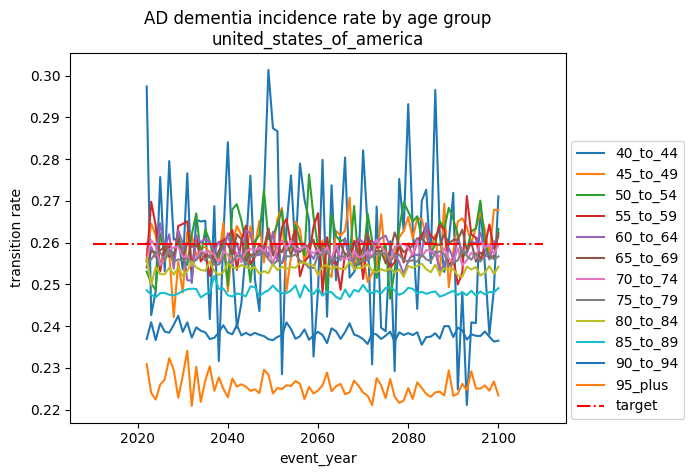

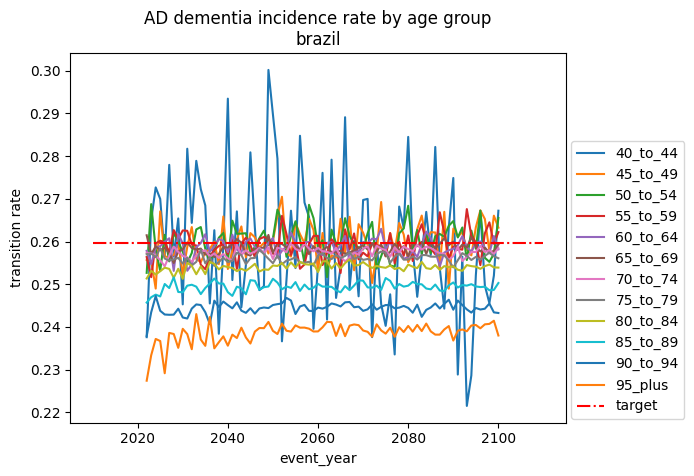

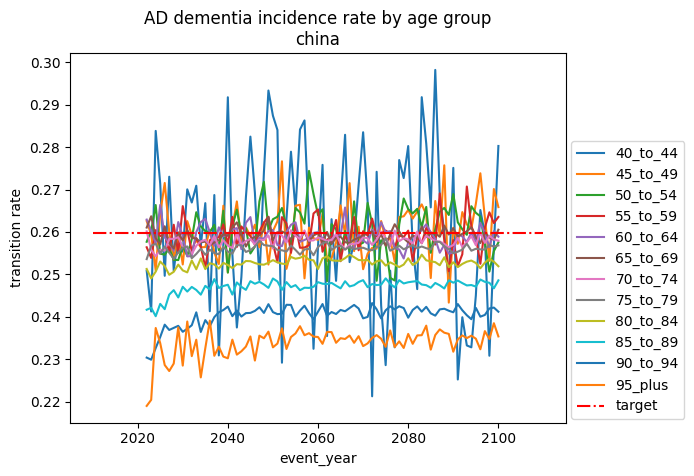

In [32]:
t = out_rates['alzheimers_mild_cognitive_impairment_state'].unstack()
for location in trans.location.unique():
    # .iloc[:,3:] filters out the first 3 age groups, which have 0 or
    # very few people
    t.loc[location].iloc[:,3:].plot(ylabel='transition rate')
    plt.title(f"AD dementia incidence rate by age group\n{location}")
    plt.hlines(1/3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [33]:
1 / 3.85

0.2597402597402597

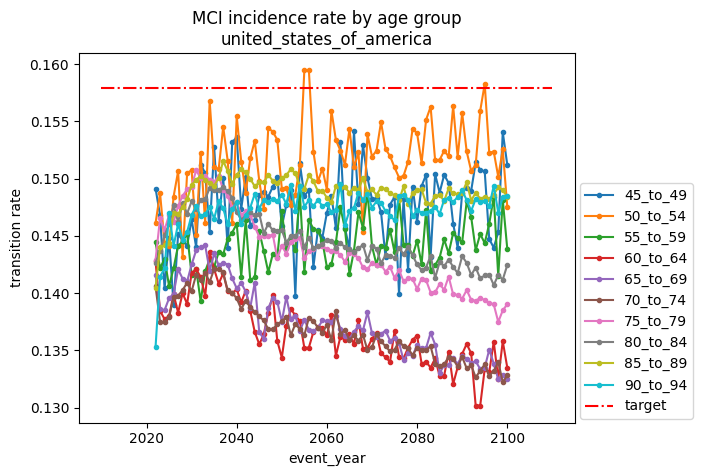

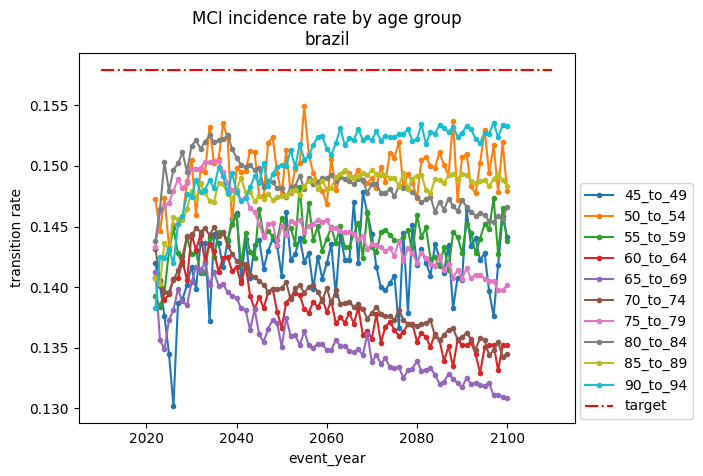

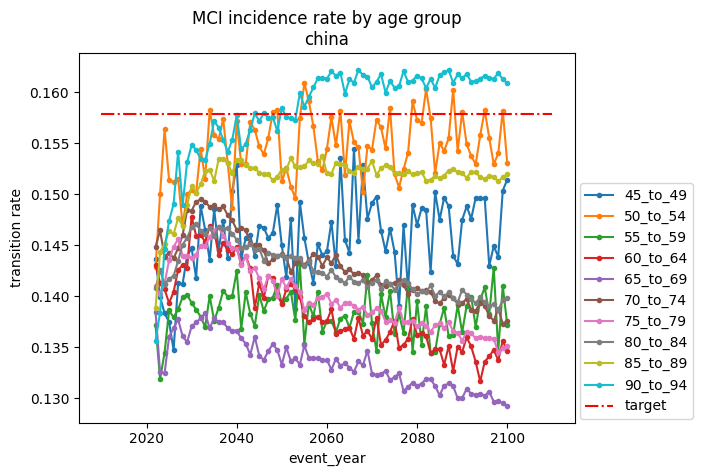

In [34]:
t = out_rates['alzheimers_blood_based_biomarker_state'].unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:,4:14].plot(marker='.', ylabel='transition rate')
    plt.title(location)
    plt.title(f"MCI incidence rate by age group\n{location}")
    # target is 1 / mean of Weibull distribution
    plt.hlines(0.15791673988674756, 2010, 2110, 'red', ls='-.', label='target')
    plt.legend(loc=(1.01, .01))

In [35]:
# prevalence \approx incidence * duration
prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()

mci_duration_est = (
    prevalence_count['alzheimers_mild_cognitive_impairment_state']
    / out_counts['alzheimers_blood_based_biomarker_state']
)
#mci_duration_est

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1955797147.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence_count = person_time.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack()


# Load counts of new simulants

In [36]:
new_sims = load_df('counts_new_simulants')
new_sims.head()

458.011317 MB for parquet file loaded into memory
26.673119 MB after converting to categorical
31.879984 MB after aggregating seeds
7.824798 MB after converting aggregated data to categoricals


age_group  event_year     sex  \
0  25_to_29        2022  Female   
1  25_to_29        2022  Female   
2  25_to_29        2022  Female   
3  25_to_29        2022  Female   
4  25_to_29        2022  Female   

                                       artifact_path  scenario input_draw  \
0  /mnt/team/simulation_science/pub/models/vivari...  baseline          1   
1  /mnt/team/simulation_science/pub/models/vivari...  baseline          6   
2  /mnt/team/simulation_science/pub/models/vivari...  baseline          7   
3  /mnt/team/simulation_science/pub/models/vivari...  baseline         24   
4  /mnt/team/simulation_science/pub/models/vivari...  baseline         35   

   value                  location  
0    0.0  united_states_of_america  
1    0.0  united_states_of_america  
2    0.0  united_states_of_america  
3    0.0  united_states_of_america  
4    0.0  united_states_of_america

In [37]:
new_sims_by_year_and_age = new_sims.groupby(['location', 'event_year', 'age_group', ]).value.sum()

bbbm_duration_est = (
    prevalence_count['alzheimers_blood_based_biomarker_state']
    / new_sims_by_year_and_age
)
#bbbm_duration_est

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/2629163193.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_sims_by_year_and_age = new_sims.groupby(['location', 'event_year', 'age_group', ]).value.sum()


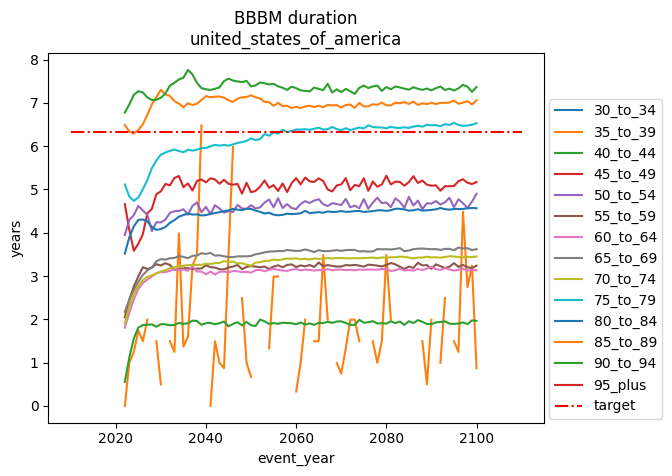

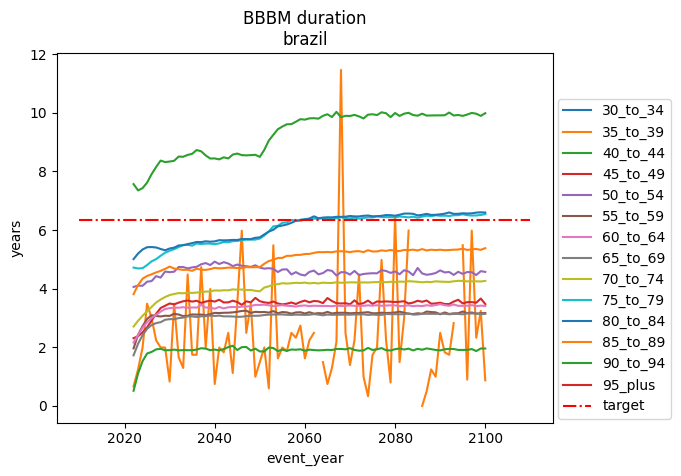

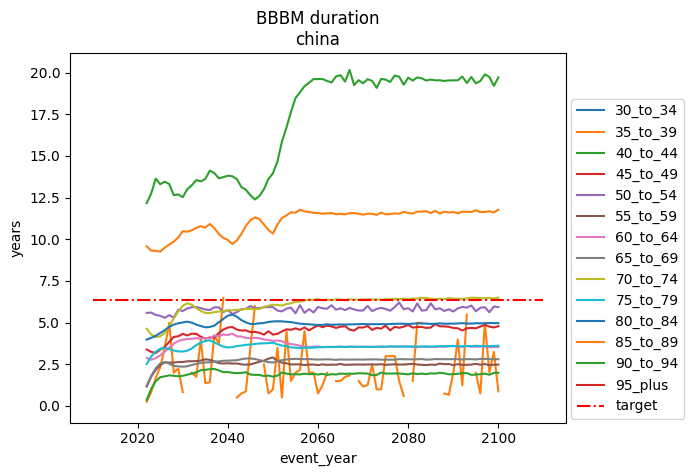

In [38]:
t = bbbm_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    # Target is mean of Weibull distribution
    plt.hlines(6.332450889735727, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'BBBM duration\n{location}')
    plt.legend(loc=(1.01, .01))

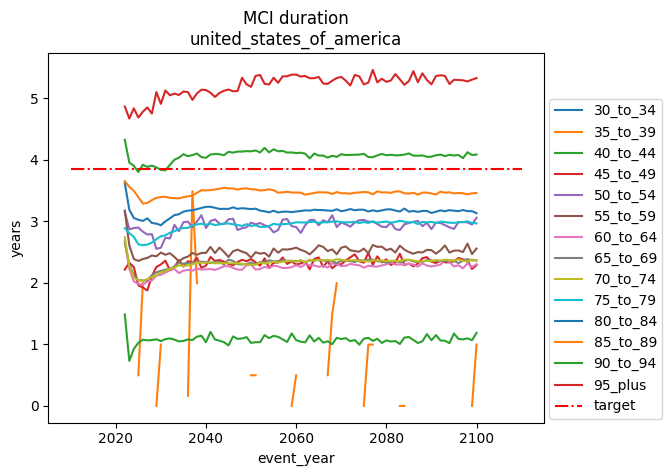

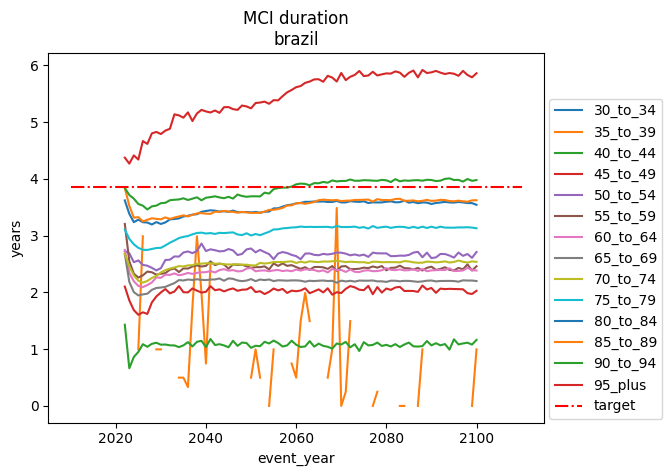

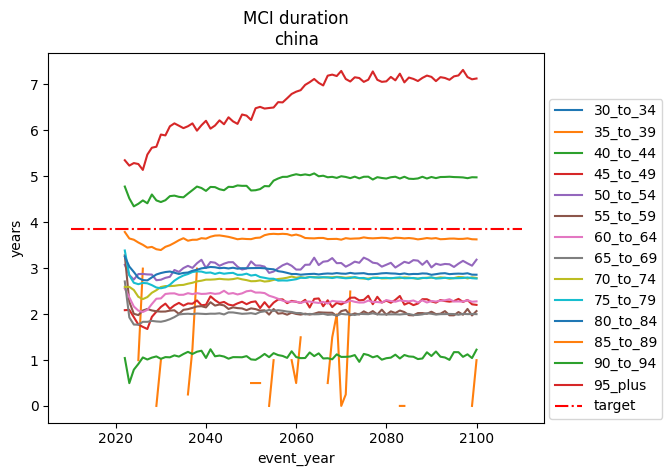

In [39]:
t = mci_duration_est.unstack()
for location in trans.location.unique():
    t.loc[location].iloc[:, 1:].plot(ylabel='years')
    plt.hlines(3.85, 2010, 2110, 'red', ls='-.', label='target')
    plt.title(f'MCI duration\n{location}')
    plt.legend(loc=(1.01, .01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [40]:
age_dictionary.age_group_id

4      10
5      11
6      12
7      13
8      14
9      15
10     16
11     17
12     18
13     19
14     20
15     30
16     31
17     32
18    235
Name: age_group_id, dtype: int64

In [41]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

# Load deaths dataframe
deaths = load_df('deaths')

def calculate_ocmr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time.groupby(cols).sum(numeric_only=True)

    # deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    # NOTE: I'm not sure why/whether this .loc was necessary...
    ocmr3 = ocmr2#.loc[ocmr2['age_group_id'].isin(age_group_ids)]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr(person_time, deaths)

1150.644503 MB for parquet file loaded into memory
67.556476 MB after converting to categorical
66.601341 MB after aggregating seeds
18.490655 MB after converting aggregated data to categoricals


<timed exec>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


CPU times: user 9.05 s, sys: 292 ms, total: 9.34 s
Wall time: 9.06 s


In [42]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    
    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f'cause.all_causes.cause_specific_mortality_rate')
    b = art.load(f'cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate')

    data1 = (a - b.droplevel(['year_start', 'year_end'])).dropna()
    data2 = (data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(['mean', '2.5%', '97.5%']).reset_index())
    data3 = data2.merge(age_dictionary, on=['age_start','age_end'])
    # NOTE: I'm not sure why/whether this .loc was necessary...
    data4 = data3#.loc[data3['age_group_id'].isin(age_group_ids)]
    data4['measure'] = 'acmr'
    data4['location'] = locations[artifact_dirs.index(artifact_dir)]
    art_ocmr = pd.concat([art_ocmr, data4])
#art_ocmr

In [43]:
art_data = art_ocmr
# location = 'United_States_Of_America'
sex='Female'
year=2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [44]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030,2040,2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f'C{j}'
                plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.event_year == year) & (sim_data.sex == sex)]
                if art_year is None:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]
                else:
                    art_plot = art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == art_year)]

                ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
                ax[i].fill_between(art_plot.age_start, art_plot['2.5%'], art_plot['97.5%'], alpha=0.2, color=color)

                ax[i].plot(art_plot.age_start, art_plot['mean'], linestyle='--', label=f'Artifact {sex}', color=color, linewidth=3)
                ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}', color=color)

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(.5, .95, f"{year}", va='top', ha='center', transform=ax[i].transAxes)
#                 ax[i].tick_params(axis='x', labelrotation=90)
                
                if i == 2:
                    ax[i].set_xlabel("Age Group")
                    
                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
#                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)


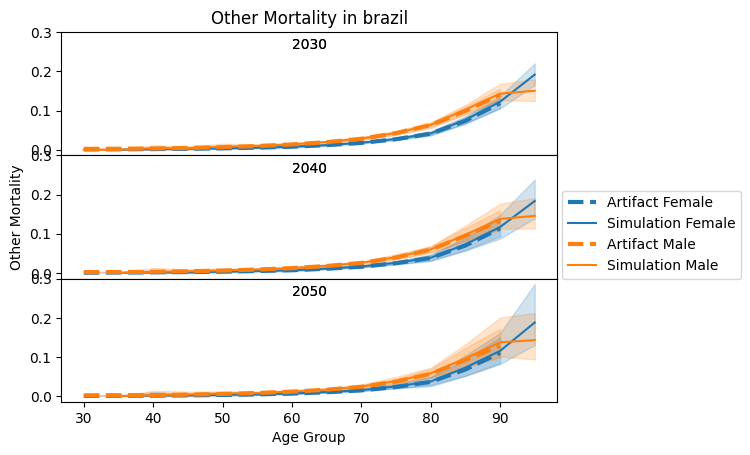

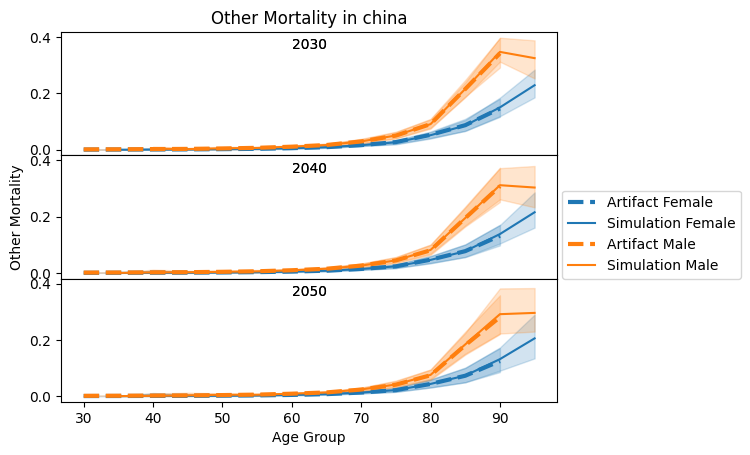

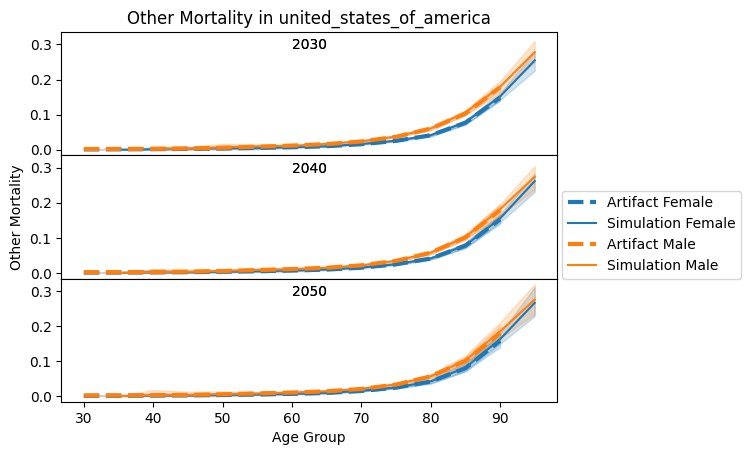

In [45]:
age_group_plot('Other Mortality', sim_ocmr, art_ocmr)

In [46]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[(sim_data.location == location) & (sim_data.age_start == age_start) & (sim_data.sex == sex)]

            plt.plot(plot_data.event_year, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.title(f"{measure} in {location} Over Time Among Age Start Group {age_start}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

In [47]:
person_time

measure entity_type                                  entity  \
0        person_time       cause  alzheimers_disease_and_other_dementias   
1        person_time       cause  alzheimers_disease_and_other_dementias   
2        person_time       cause  alzheimers_disease_and_other_dementias   
3        person_time       cause  alzheimers_disease_and_other_dementias   
4        person_time       cause  alzheimers_disease_and_other_dementias   
...              ...         ...                                     ...   
6398995  person_time       cause  alzheimers_disease_and_other_dementias   
6398996  person_time       cause  alzheimers_disease_and_other_dementias   
6398997  person_time       cause  alzheimers_disease_and_other_dementias   
6398998  person_time       cause  alzheimers_disease_and_other_dementias   
6398999  person_time       cause  alzheimers_disease_and_other_dementias   

                                         sub_entity age_group  event_year  \
0            alzheimers_blood_based_biomarker_state  25_to_29        2022   
1            alzheimers_blood_based_biomarker_state  25_to_29        2022   
2            alzheimers_blood_based_biomarker_state  25_to_29        2022   
3            alzheimers_blood_based_biomarker_state  25_to_29        2022   
4            alzheimers_blood_based_biomarker_state  25_to_29        2022   
...                                             ...       ...         ...   
6398995  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398996  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398997  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398998  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398999  alzheimers_mild_cognitive_impairment_state   95_plus        2100   

            sex                  treatment  \
0        Female  no_effect_after_treatment   
1        Female  no_effect_after_treatment   
2        Female  no_effect_after_treatment   
3        Female  no_effect_after_treatment   
4        Female  no_effect_after_treatment   
...         ...                        ...   
6398995    Male              waning_effect   
6398996    Male              waning_effect   
6398997    Male              waning_effect   
6398998    Male              waning_effect   
6398999    Male              waning_effect   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
6398995  /mnt/team/simulation_science/pub/models/vivari...   
6398996  /mnt/team/simulation_science/pub/models/vivari...   
6398997  /mnt/team/simulation_science/pub/models/vivari...   
6398998  /mnt/team/simulation_science/pub/models/vivari...   
6398999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario input_draw     value  \
0                          baseline          1  0.000000   
1                          baseline          6  0.000000   
2                          baseline          7  0.000000   
3                          baseline         24  0.000000   
4                          baseline         35  0.000000   
...                             ...        ...       ...   
6398995  bbbm_testing_and_treatment        235  5.979466   
6398996  bbbm_testing_and_treatment        236  2.989733   
6398997  bbbm_testing_and_treatment        245  1.993155   
6398998  bbbm_testing_and_treatment        248  0.996578   
6398999  bbbm_testing_and_treatment        249  5.481177   

                         location  
0        united_states_of_america  
1        united_states_of_america  
2        united_states_of_america  
3        uni

In [48]:
deaths

measure entity_type                    entity  \
0       deaths       cause  alzheimers_disease_state   
1       deaths       cause  alzheimers_disease_state   
2       deaths       cause  alzheimers_disease_state   
3       deaths       cause  alzheimers_disease_state   
4       deaths       cause  alzheimers_disease_state   
...        ...         ...                       ...   
710995  deaths       cause              other_causes   
710996  deaths       cause              other_causes   
710997  deaths       cause              other_causes   
710998  deaths       cause              other_causes   
710999  deaths       cause              other_causes   

                      sub_entity age_group  event_year     sex  \
0       alzheimers_disease_state  25_to_29        2022  Female   
1       alzheimers_disease_state  25_to_29        2022  Female   
2       alzheimers_disease_state  25_to_29        2022  Female   
3       alzheimers_disease_state  25_to_29        2022  Female   
4       alzheimers_disease_state  25_to_29        2022  Female   
...                          ...       ...         ...     ...   
710995              other_causes   95_plus        2100    Male   
710996              other_causes   95_plus        2100    Male   
710997              other_causes   95_plus        2100    Male   
710998              other_causes   95_plus        2100    Male   
710999              other_causes   95_plus        2100    Male   

                                            artifact_path  \
0       /mnt/team/simulation_science/pub/models/vivari...   
1       /mnt/team/simulation_science/pub/models/vivari...   
2       /mnt/team/simulation_science/pub/models/vivari...   
3       /mnt/team/simulation_science/pub/models/vivari...   
4       /mnt/team/simulation_science/pub/models/vivari...   
...                                                   ...   
710995  /mnt/team/simulation_science/pub/models/vivari...   
710996  /mnt/team/simulation_science/pub/models/vivari...   
710997  /mnt/team/simulation_science/pub/models/vivari...   
710998  /mnt/team/simulation_science/pub/models/vivari...   
710999  /mnt/team/simulation_science/pub/models/vivari...   

                          scenario input_draw  value                  location  
0                         baseline          1    0.0  united_states_of_america  
1                         baseline          6    0.0  united_states_of_america  
2                         baseline          7    0.0  united_states_of_america  
3                         baseline         24    0.0  united_states_of_america  
4                         baseline         35    0.0  united_states_of_america  
...                            ...        ...    ...                       ...  
710995  bbbm_testing_and_treatment        235  348.0                     china  
710996  bbbm_testing_and_treatment        236  153.0                     china  
710997  bbbm_testing_and_treatment        245  148.0                     china  
710998  bbbm_testing_and_treatment        248  192.0                     china  
710999  bbbm_testing_and_treatment        249  447.0                     china  

[711000 rows x 12 columns]

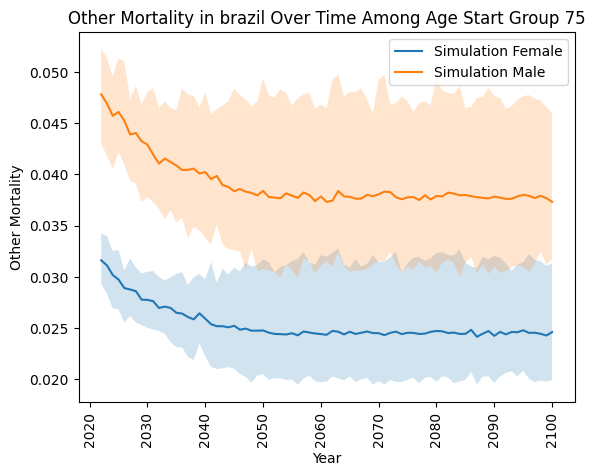

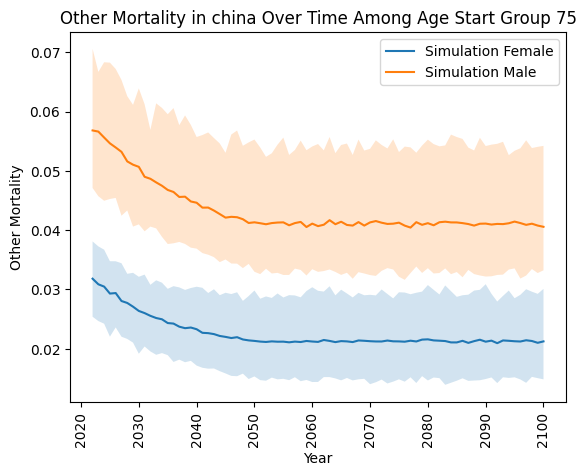

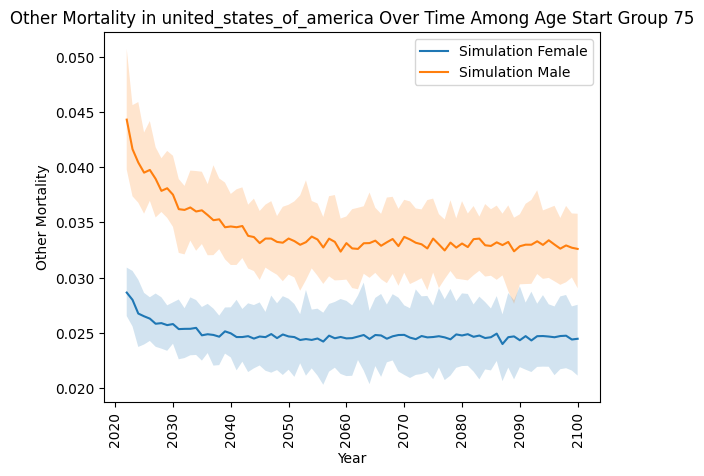

<Figure size 640x480 with 0 Axes>

In [49]:
over_time_plot('Other Mortality', sim_ocmr, 75)

## Validate Alzheimer’s dementia EMR against GBD

In [50]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
scenario = 'baseline'
# severity = 'severe'

def calculate_emr(person_time, deaths):
    # person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    infected = person_time.loc[
        (person_time.sub_entity == f'alzheimers_disease_state')
        & (person_time.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(infected) > 0

    # deaths0 = load_df('deaths')
    deaths = deaths.loc[
        (deaths.sub_entity == f'alzheimers_disease_state')
        & (deaths.scenario == scenario)
    ].groupby(cols, observed=True).sum(numeric_only=True)
    assert len(deaths) > 0
    
    mr = (deaths / infected)[['value']].reset_index()

    mr = mr.merge(age_dictionary, on=['age_group'])
    # mr = mr.loc[mr['age_group_id'].isin(age_group_ids)]
    mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']
                    ).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return mr1

sim_emr = calculate_emr(person_time, deaths)

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1372640935.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mr1 = mr.groupby([c for c in cols if c != 'input_draw'] + ['age_start']


In [51]:
sim_emr

event_year                  location age_group     sex  scenario  \
0           2022                    brazil  25_to_29  Female  baseline   
1           2022                    brazil  25_to_29    Male  baseline   
2           2022                    brazil  30_to_34  Female  baseline   
3           2022                    brazil  30_to_34    Male  baseline   
4           2022                    brazil  35_to_39  Female  baseline   
...          ...                       ...       ...     ...       ...   
7105        2100  united_states_of_america  85_to_89    Male  baseline   
7106        2100  united_states_of_america  90_to_94  Female  baseline   
7107        2100  united_states_of_america  90_to_94    Male  baseline   
7108        2100  united_states_of_america   95_plus  Female  baseline   
7109        2100  united_states_of_america   95_plus    Male  baseline   

      age_start  count      mean       std       min      2.5%       50%  \
0          25.0    0.0       NaN       NaN       NaN       NaN       NaN   
1          25.0    0.0       NaN       NaN       NaN       NaN       NaN   
2          30.0    0.0       NaN       NaN       NaN       NaN       NaN   
3          30.0    0.0       NaN       NaN       NaN       NaN       NaN   
4          35.0    0.0       NaN       NaN       NaN       NaN       NaN   
...         ...    ...       ...       ...       ...       ...       ...   
7105       85.0   25.0  0.111690  0.015227  0.086262  0.089739  0.108184   
7106       90.0   25.0  0.077557  0.006227  0.069322  0.069693  0.076454   
7107       90.0   25.0  0.138913  0.018748  0.107328  0.110443  0.136319   
7108       95.0   25.0  0.125216  0.023839  0.076493  0.081913  0.128300   
7109       95.0   25.0  0.170883  0.028115  0.115924  0.126677  0.167894   

         97.5%       max  
0          NaN       NaN  
1          NaN       NaN  
2          NaN       NaN  
3          NaN       NaN  
4          NaN       NaN  
...        ...       ...  
7105  0.138680  0.142276  
7106  0.090212  0.092491  
7107  0.175688  0.176929  
7108  0.161385  0.162818  
7109  0.223711  0.243943  

[7110 rows x 14 columns]

In [52]:
def load_artifact_cause_data(measure, year_start=2025):
    # out = pd.DataFrame()
    artifact_data = []
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir, filter_terms = [f'year_start=={year_start}'])
        data = art.load(f'cause.{measure}')
        data = (data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
                .filter(['mean', '2.5%', '97.5%']).reset_index())
        data = data.merge(age_dictionary, on=['age_start','age_end'])
        # data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data['measure'] = measure
        data['location'] = locations[artifact_dirs.index(artifact_dir)]
        # out = pd.concat([out, data])
        artifact_data.append(data)
    out = pd.concat(artifact_data)
    return out

In [53]:
print(art)

Artifact containing the following keys:
metadata
	keyspace
	locations
population
	location
	structure
	age_bins
	demographic_dimensions
	theoretical_minimum_risk_life_expectancy
	scaling_factor
cause
	all_causes
		cause_specific_mortality_rate
	alzheimers
		prevalence
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		mci_to_dementia_transition_rate
		susceptible_to_bbbm_transition_count
		population_incidence_rate
		excess_mortality_rate
		mci_disability_weight
	alzheimers_disease_and_other_dementias
		disability_weight
		restrictions
		cause_specific_mortality_rate
	alzheimers_consistent
		population_incidence_any
		prevalence_any
		population_incidence_dementia
		excess_mortality_rate
		bbbm_conditional_prevalence
		mci_conditional_prevalence
		ode_errors
		susceptible_to_bbbm_transition_count
		dementia_conditional_prevalence
covariate
	live_births_by_sex
		estimate
testing_rates
	csf
	pet
treatment
	relative_risk



In [54]:
art_emr = load_artifact_cause_data(f'alzheimers_consistent.excess_mortality_rate')
art_emr.head()

sex  age_start  age_end  year_start  year_end          mean          2.5%  \
0  Male         30       35        2025      2026  8.457607e-09  3.059188e-10   
1  Male         35       40        2025      2026  7.859428e-09  1.754442e-10   
2  Male         40       45        2025      2026  4.657251e-03  3.360544e-03   
3  Male         45       50        2025      2026  1.756943e-02  1.377623e-02   
4  Male         50       55        2025      2026  2.927732e-02  2.317085e-02   

          97.5%  age_group_id age_group_name age_group  \
0  2.361783e-08            11       30 to 34  30_to_34   
1  2.269876e-08            12       35 to 39  35_to_39   
2  5.947937e-03            13       40 to 44  40_to_44   
3  2.114747e-02            14       45 to 49  45_to_49   
4  3.497669e-02            15       50 to 54  50_to_54   

                                       measure                  location  
0  alzheimers_consistent.excess_mortality_rate  united_states_of_america  
1  alzheimers_consistent.excess_mortality_rate  united_states_of_america  
2  alzheimers_consistent.excess_mortality_rate  united_states_of_america  
3  alzheimers_consistent.excess_mortality_rate  united_states_of_america  
4  alzheimers_consistent.excess_mortality_rate  united_states_of_america

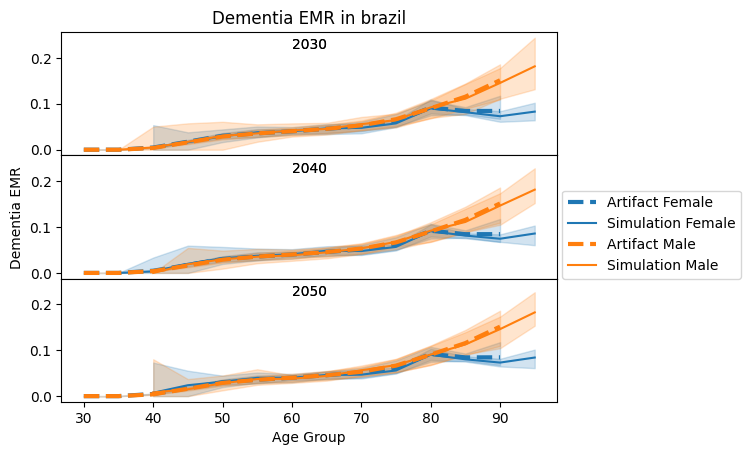

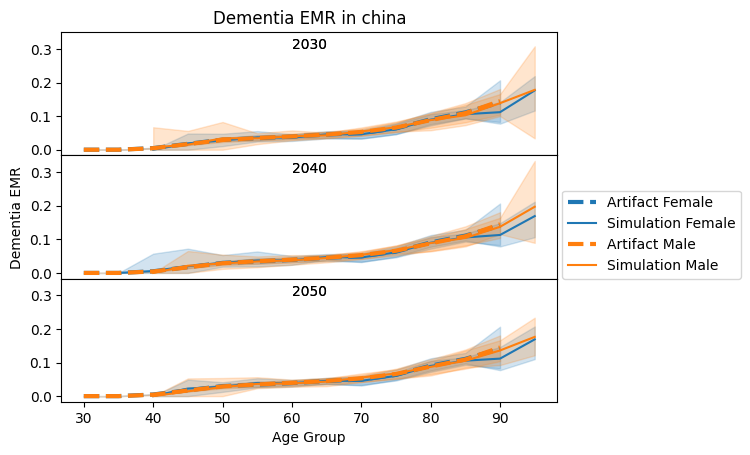

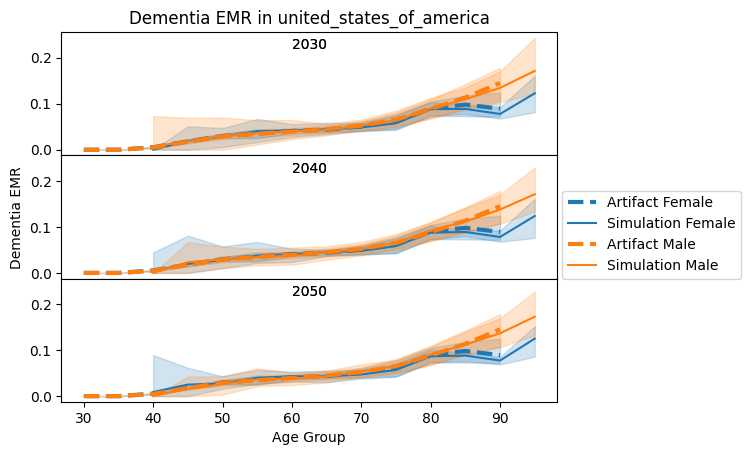

In [55]:
age_group_plot(f'Dementia EMR', sim_emr, art_emr, art_year=2025)

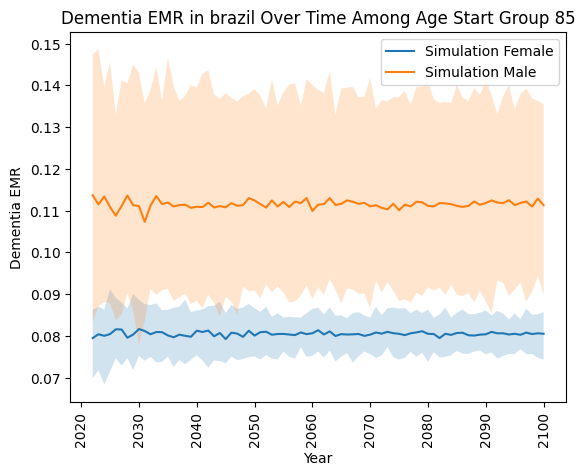

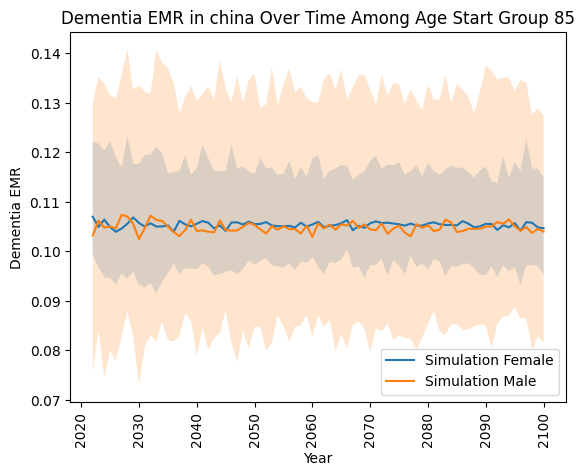

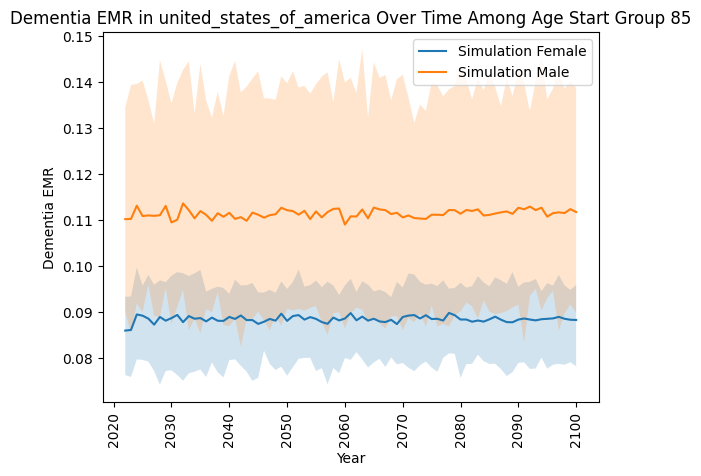

<Figure size 640x480 with 0 Axes>

In [56]:
over_time_plot(f'Dementia EMR', sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [57]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            # TODO: Which of these keys should I use?
            # # Output of MCMC, incidence of BBBM used in simulation:
            # 'cause.alzheimers_consistent.population_incidence_dementia'
            # # Used as input (target for calibration):
            'cause.alzheimers.population_incidence_rate'
        ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    # df['location'] = df.location.str.replace(' ', '_').str.lower()
    art_incidence_data.append(df)
    
art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f'draw_{i}'] *= art_incidence_data[f'draw_{i}_pop']
    del art_incidence_data[f'draw_{i}_pop']
art_incidence_data.tail()
    

draw_0  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      10036.380458   
                                2047       2048      10886.414243   
                                2048       2049      11909.983883   
                                2049       2050      12854.593501   
                                2050       2051      13543.099558   

                                                           draw_1  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      10975.540686   
                                2047       2048      11976.340384   
                                2048       2049      13181.044703   
                                2049       2050      14341.664939   
                                2050       2051      15274.164458   

                                                           draw_2  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      14639.345612   
                                2047       2048      16105.125421   
                                2048       2049      17886.225848   
                                2049       2050      19614.244921   
                                2050       2051      20998.739880   

                                                           draw_3  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      17252.333916   
                                2047       2048      19077.944375   
                                2048       2049      21286.719206   
                                2049       2050      23469.834134   
                                2050       2051      25309.259500   

                                                          draw_4  \
sex  age_start age_end location year_start year_end                
Male 95.0      125.0   China    2046       2047      6571.742477   
                                2047       2048      7008.987709   
                                2048       2049      7534.143545   
                                2049       2050      7999.585874   
                                2050       2051      8307.429211   

                                                           draw_5  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      15242.188853   
                                2047       2048      16914.983116   
                                2048       2049      18965.253790   
                                2049       2050      21015.394615   
                                2050       2051      22728.522683   

                                                           draw_6  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      11788.453044   
                                2047       2048      12854.725663   
                                2048       2049      14117.323639   
                                2049       2050      15321.262643   
                                2050       2051      16251.736589   

                                                           draw_7  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      13249.262998   
                                2047       2048      14798.124330   
                                2048       2049      16678.689818   
                                2049       2050      18582.650203   
                                2050       2051      20241.882373   

                                                           draw_8  \
sex  age_start age_end location year_start year_end                 
Male 95.0      125.0   China    2046       2047      316

In [58]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load('population.structure').reset_index() 
    temp['location'] = temp.location.str.replace(' ', '_').str.lower()
    
    df_prev_pop = pd.merge(
        art.load('population.scaling_factor').query("year_start == 2025"),
        art.load('population.structure').query("year_start==2025").droplevel(['year_start', 'year_end']),
        left_index=True,
        right_index=True,
        suffixes=['_prev', '_pop']
    )
    prev = ((df_prev_pop.filter(like='draw_').filter(like='_prev')
            * df_prev_pop.filter(like='draw_').filter(like='_pop').values).mean(axis=1)).sum(axis=0)
    # TODO: use draw-specific scale instead of mean
    
    # NOTE: population 100_000 for V&V (5 seeds), 2_000_000 for final
    # runs (100 seeds)
    # ratio = 2_000_000 / prev
    ratio = 100_000 / prev
    print(ratio)

    temp['ratio'] = ratio

    temp = temp.rename(columns={'year_start': 'event_year'})
    temp = temp.merge(age_dictionary, on=['age_start','age_end'])
    # temp = temp.loc[temp['age_group_id'].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
#scale

0.012818306084625083
0.02960834599136685
0.003274362508962734


In [59]:
scale.groupby('location').ratio.describe()/5  # compare to 0.0035494897066482814 in interactive sim for USA

count      mean           std       min       25%  \
location                                                                      
brazil                    180.0  0.005922  6.942752e-19  0.005922  0.005922   
china                     180.0  0.000655  2.603532e-19  0.000655  0.000655   
united_states_of_america  180.0  0.002564  3.471376e-19  0.002564  0.002564   

                               50%       75%       max  
location                                                
brazil                    0.005922  0.005922  0.005922  
china                     0.000655  0.000655  0.000655  
united_states_of_america  0.002564  0.002564  0.002564

In [60]:
# new_sims = load_df('counts_new_simulants')
new_sims.head()

age_group  event_year     sex  \
0  25_to_29        2022  Female   
1  25_to_29        2022  Female   
2  25_to_29        2022  Female   
3  25_to_29        2022  Female   
4  25_to_29        2022  Female   

                                       artifact_path  scenario input_draw  \
0  /mnt/team/simulation_science/pub/models/vivari...  baseline          1   
1  /mnt/team/simulation_science/pub/models/vivari...  baseline          6   
2  /mnt/team/simulation_science/pub/models/vivari...  baseline          7   
3  /mnt/team/simulation_science/pub/models/vivari...  baseline         24   
4  /mnt/team/simulation_science/pub/models/vivari...  baseline         35   

   value                  location  
0    0.0  united_states_of_america  
1    0.0  united_states_of_america  
2    0.0  united_states_of_america  
3    0.0  united_states_of_america  
4    0.0  united_states_of_america

In [61]:
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [62]:
# trans = load_df('transition_count_alzheimers_disease_and_other_dementias')
new_ad_dementia = trans[trans.sub_entity == 'alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state']
new_ad_dementia

measure entity_type                                  entity  \
711000   transition_count       cause  alzheimers_disease_and_other_dementias   
711001   transition_count       cause  alzheimers_disease_and_other_dementias   
711002   transition_count       cause  alzheimers_disease_and_other_dementias   
711003   transition_count       cause  alzheimers_disease_and_other_dementias   
711004   transition_count       cause  alzheimers_disease_and_other_dementias   
...                   ...         ...                                     ...   
4265995  transition_count       cause  alzheimers_disease_and_other_dementias   
4265996  transition_count       cause  alzheimers_disease_and_other_dementias   
4265997  transition_count       cause  alzheimers_disease_and_other_dementias   
4265998  transition_count       cause  alzheimers_disease_and_other_dementias   
4265999  transition_count       cause  alzheimers_disease_and_other_dementias   

                                                sub_entity age_group  \
711000   alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
711001   alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
711002   alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
711003   alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
711004   alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
...                                                    ...       ...   
4265995  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
4265996  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
4265997  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
4265998  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
4265999  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   

         event_year     sex                  treatment  \
711000         2022  Female  no_effect_after_treatment   
711001         2022  Female  no_effect_after_treatment   
711002         2022  Female  no_effect_after_treatment   
711003         2022  Female  no_effect_after_treatment   
711004         2022  Female  no_effect_after_treatment   
...             ...     ...                        ...   
4265995        2100    Male              waning_effect   
4265996        2100    Male              waning_effect   
4265997        2100    Male              waning_effect   
4265998        2100    Male              waning_effect   
4265999        2100    Male              waning_effect   

                                             artifact_path  \
711000   /mnt/team/simulation_science/pub/models/vivari...   
711001   /mnt/team/simulation_science/pub/models/vivari...   
711002   /mnt/team/simulation_science/pub/models/vivari...   
711003   /mnt/team/simulation_science/pub/models/vivari...   
711004   /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
4265995  /mnt/team/simulation_science/pub/models/vivari...   
4265996  /mnt/team/simulation_science/pub/models/vivari...   
4265997  /mnt/team/simulation_science/pub/models/vivari...   
4265998  /mnt/team/simulation_science/pub/models/vivari...   
4265999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario input_draw  value  \
711000                     baseline          1    0.0   
711001                     baseline          6    0.0   
711002                     baseline          7    0.0   
711003                     baseline         24    0.0   
711004                     baseline         35    0.0   
...                             ...        ...    ...   
4265995  bbbm_testing_and_treatment        235    1.0   
4265996  bbbm_testing_and_treatment        236    2.0   
4265997  bbbm_testing_and_treatment        245    1.0   
4265998  bbbm_testing_and_treatment        248    0.0   
4265999  bbbm_testing_and_treatment        249    2.0   

                         location  
711000   united_s

In [63]:
new_sims_with_scale = new_sims.merge(scale[['location','sex','age_group','ratio','event_year']])
new_ad_dementia = new_ad_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])

In [64]:
new_ad_dementia

measure entity_type                                  entity  \
0       transition_count       cause  alzheimers_disease_and_other_dementias   
1       transition_count       cause  alzheimers_disease_and_other_dementias   
2       transition_count       cause  alzheimers_disease_and_other_dementias   
3       transition_count       cause  alzheimers_disease_and_other_dementias   
4       transition_count       cause  alzheimers_disease_and_other_dementias   
...                  ...         ...                                     ...   
782995  transition_count       cause  alzheimers_disease_and_other_dementias   
782996  transition_count       cause  alzheimers_disease_and_other_dementias   
782997  transition_count       cause  alzheimers_disease_and_other_dementias   
782998  transition_count       cause  alzheimers_disease_and_other_dementias   
782999  transition_count       cause  alzheimers_disease_and_other_dementias   

                                               sub_entity age_group  \
0       alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
1       alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
2       alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
3       alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
4       alzheimers_mild_cognitive_impairment_state_to_...  25_to_29   
...                                                   ...       ...   
782995  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
782996  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
782997  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
782998  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   
782999  alzheimers_mild_cognitive_impairment_state_to_...   95_plus   

        event_year     sex                  treatment  \
0             2022  Female  no_effect_after_treatment   
1             2022  Female  no_effect_after_treatment   
2             2022  Female  no_effect_after_treatment   
3             2022  Female  no_effect_after_treatment   
4             2022  Female  no_effect_after_treatment   
...            ...     ...                        ...   
782995        2050    Male              waning_effect   
782996        2050    Male              waning_effect   
782997        2050    Male              waning_effect   
782998        2050    Male              waning_effect   
782999        2050    Male              waning_effect   

                                            artifact_path  \
0       /mnt/team/simulation_science/pub/models/vivari...   
1       /mnt/team/simulation_science/pub/models/vivari...   
2       /mnt/team/simulation_science/pub/models/vivari...   
3       /mnt/team/simulation_science/pub/models/vivari...   
4       /mnt/team/simulation_science/pub/models/vivari...   
...                                                   ...   
782995  /mnt/team/simulation_science/pub/models/vivari...   
782996  /mnt/team/simulation_science/pub/models/vivari...   
782997  /mnt/team/simulation_science/pub/models/vivari...   
782998  /mnt/team/simulation_science/pub/models/vivari...   
782999  /mnt/team/simulation_science/pub/models/vivari...   

                          scenario input_draw  value  \
0                         baseline          1    0.0   
1                         baseline          6    0.0   
2                         baseline          7    0.0   
3                         baseline         24    0.0   
4                         baseline         35    0.0   
...                            ...        ...    ...   
782995  bbbm_testing_and_treatment        235    0.0   
782996  bbbm_testing_and_treatment        236    0.0   
782997  bbbm_testing_and_treatment        245    0.0   
782998  bbbm_testing_and_treatment        248    0.0   
782999  bbbm_testing_and_treatment        249    0.0   

                        location     ratio  
0       united_states_of_america  0.012818  
1       united_states_

In [65]:
new_sims_with_scale

age_group  event_year     sex  \
0       25_to_29        2022  Female   
1       25_to_29        2022  Female   
2       25_to_29        2022  Female   
3       25_to_29        2022  Female   
4       25_to_29        2022  Female   
...          ...         ...     ...   
130495   95_plus        2050    Male   
130496   95_plus        2050    Male   
130497   95_plus        2050    Male   
130498   95_plus        2050    Male   
130499   95_plus        2050    Male   

                                            artifact_path  \
0       /mnt/team/simulation_science/pub/models/vivari...   
1       /mnt/team/simulation_science/pub/models/vivari...   
2       /mnt/team/simulation_science/pub/models/vivari...   
3       /mnt/team/simulation_science/pub/models/vivari...   
4       /mnt/team/simulation_science/pub/models/vivari...   
...                                                   ...   
130495  /mnt/team/simulation_science/pub/models/vivari...   
130496  /mnt/team/simulation_science/pub/models/vivari...   
130497  /mnt/team/simulation_science/pub/models/vivari...   
130498  /mnt/team/simulation_science/pub/models/vivari...   
130499  /mnt/team/simulation_science/pub/models/vivari...   

                          scenario input_draw  value  \
0                         baseline          1    0.0   
1                         baseline          6    0.0   
2                         baseline          7    0.0   
3                         baseline         24    0.0   
4                         baseline         35    0.0   
...                            ...        ...    ...   
130495  bbbm_testing_and_treatment        235    0.0   
130496  bbbm_testing_and_treatment        236    0.0   
130497  bbbm_testing_and_treatment        245    0.0   
130498  bbbm_testing_and_treatment        248    0.0   
130499  bbbm_testing_and_treatment        249    0.0   

                        location     ratio  
0       united_states_of_america  0.012818  
1       united_states_of_america  0.012818  
2       united_states_of_america  0.012818  
3       united_states_of_america  0.012818  
4       united_states_of_america  0.012818  
...                          ...       ...  
130495                     china  0.003274  
130496                     china  0.003274  
130497                     china  0.003274  
130498                     china  0.003274  
130499                     china  0.003274  

[130500 rows x 9 columns]

In [66]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']

new_sims_with_scale['total_incidence'] = new_sims_with_scale['value'] / new_sims_with_scale['ratio']
new_ad_dementia['total_incidence'] = new_ad_dementia['value'] / new_ad_dementia['ratio']

def summarize(df):
    df = df.groupby(cols, observed=True).sum(numeric_only=True)
    df = df.groupby([c for c in cols if c != 'input_draw'], observed=True
                    ).describe(percentiles=[0.025,0.975])['total_incidence'].reset_index()

    df = df.merge(age_dictionary, on=['age_group'])
    # df = df.loc[df['age_group_id'].isin(age_group_ids)]

    return df

new_sims_summary = summarize(new_sims_with_scale)

In [67]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

event_year                  location age_group     sex  \
0           2022                    brazil  25_to_29  Female   
1           2022                    brazil  25_to_29  Female   
2           2022                    brazil  25_to_29    Male   
3           2022                    brazil  25_to_29    Male   
4           2022                    brazil  30_to_34  Female   
...          ...                       ...       ...     ...   
5215        2050  united_states_of_america  90_to_94    Male   
5216        2050  united_states_of_america   95_plus  Female   
5217        2050  united_states_of_america   95_plus  Female   
5218        2050  united_states_of_america   95_plus    Male   
5219        2050  united_states_of_america   95_plus    Male   

                        scenario  count          mean          std  \
0                       baseline   25.0      0.000000     0.000000   
1     bbbm_testing_and_treatment   25.0      0.000000     0.000000   
2                       baseline   25.0      0.000000     0.000000   
3     bbbm_testing_and_treatment   25.0      0.000000     0.000000   
4                       baseline   25.0      0.000000     0.000000   
...                          ...    ...           ...          ...   
5215  bbbm_testing_and_treatment   25.0  38441.896827  4252.225649   
5216                    baseline   25.0  24636.640592  3565.862294   
5217  bbbm_testing_and_treatment   25.0  24652.243277  3566.786673   
5218                    baseline   25.0   9895.223219  1956.136476   
5219  bbbm_testing_and_treatment   25.0   9904.584831  1965.164293   

               min          2.5%           50%         97.5%           max  \
0         0.000000      0.000000      0.000000      0.000000      0.000000   
1         0.000000      0.000000      0.000000      0.000000      0.000000   
2         0.000000      0.000000      0.000000      0.000000      0.000000   
3         0.000000      0.000000      0.000000      0.000000      0.000000   
4         0.000000      0.000000      0.000000      0.000000      0.000000   
...            ...           ...           ...           ...           ...   
5215  31283.384665  31891.889404  38148.566337  46464.797772  47120.110568   
5216  18879.249598  19581.370451  24496.216421  31657.849120  32921.666655   
5217  18957.263026  19612.575822  24574.229849  31689.054491  32999.680083   
5218   6553.127960   6974.400471   9907.705368  13714.760659  14744.537909   
5219   6553.127960   6974.400471   9985.718796  13714.760659  14744.537909   

      age_group_id age_group_name  age_start  age_end  
0               10       25 to 29       25.0     30.0  
1               10       25 to 29       25.0     30.0  
2               10       25 to 29       25.0     30.0  
3               10       25 to 29       25.0     30.0  
4               11       30 to 34       30.0     35.0  
...            ...            ...        ...      ...  
5215            32       90 to 94       90.0     95.0  
5216           235        95 plus       95.0    125.0  
5217           235        95 plus       95.0    125.0  
5218           235        95 plus       95.0    125.0  
5219           235        95 plus       95.0    125.0  

[5220 rows x 17 columns]

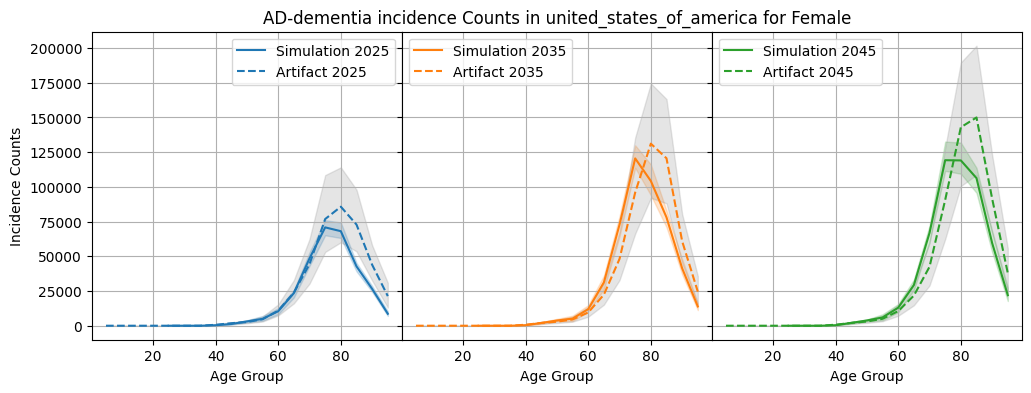

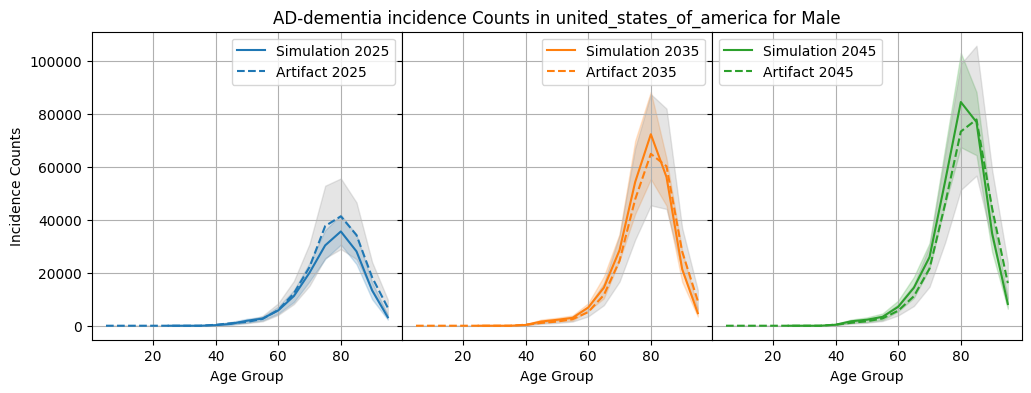

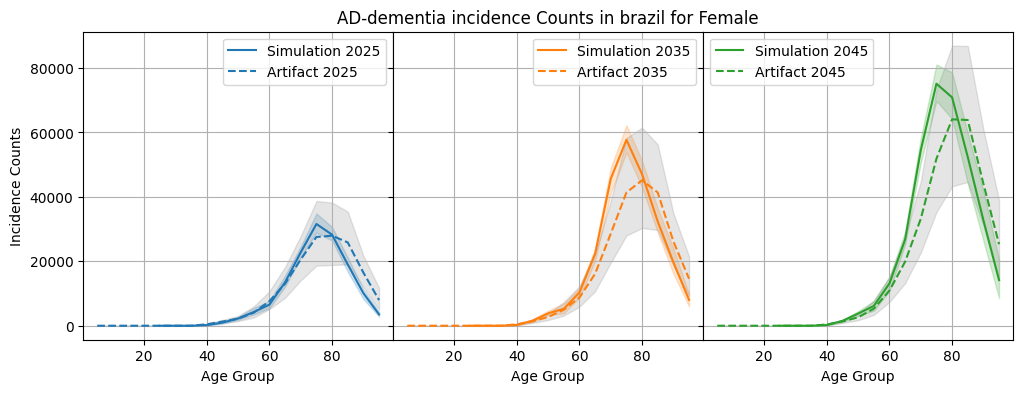

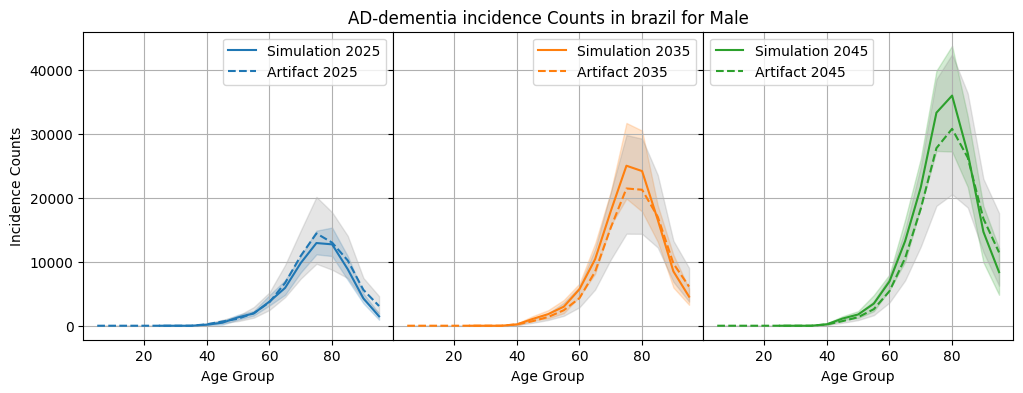

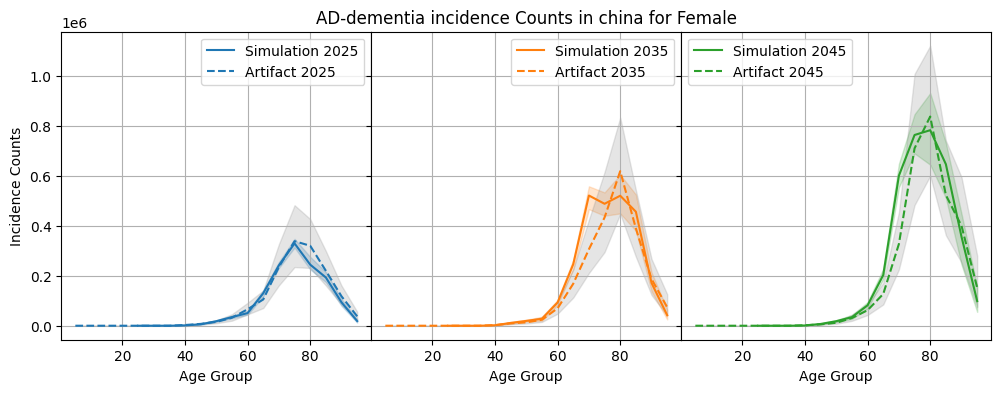

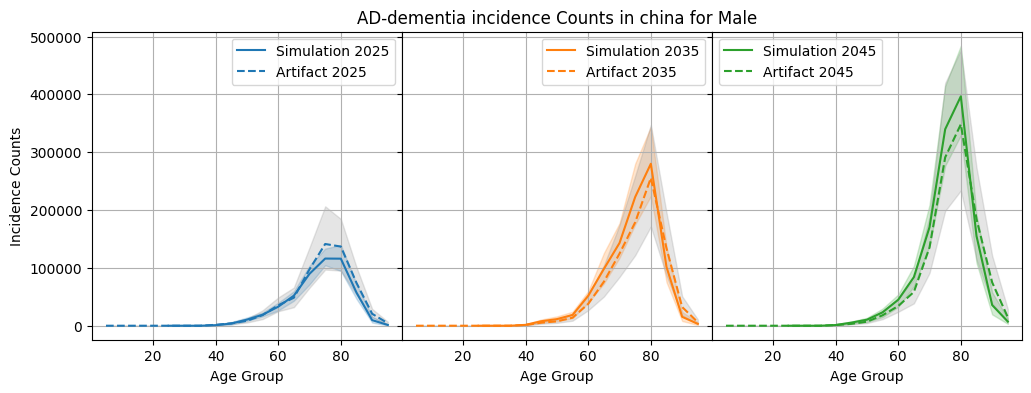

In [68]:
scenario = 'baseline'
for location in new_sims_with_scale.location.unique():
    for sex in new_sims_with_scale.sex.unique():
        fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(12,4))
        plt.subplots_adjust(wspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f'C{i}'
            plot_data = new_ad_dementia_summary.query(
                'location == @location and event_year == @year and sex == @sex'
                ' and scenario == @scenario'
                )

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            ax[i].fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2, color=color)
            ax[i].fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2, color='grey')
            ax[i].plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {year}', color=color)
            ax[i].plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {year}', color=color, linestyle='--')
            ax[i].grid(True)
            if i == 1:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
#             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 0:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend()#(loc=(1.01, 0))


I did some manual checks against GBD compare to make sure these were less than those, with the expectation they are about half. 

In [69]:
plot_data

event_year location age_group   sex  scenario  count           mean  \
4202        2045    china  25_to_29  Male  baseline   25.0       0.000000   
4206        2045    china  30_to_34  Male  baseline   25.0       0.000000   
4210        2045    china  35_to_39  Male  baseline   25.0       0.000000   
4214        2045    china  40_to_44  Male  baseline   25.0    1172.747364   
4218        2045    china  45_to_49  Male  baseline   25.0    5314.011492   
4222        2045    china  50_to_54  Male  baseline   25.0   10420.348971   
4226        2045    china  55_to_59  Male  baseline   25.0   23112.895958   
4230        2045    china  60_to_64  Male  baseline   25.0   44882.018896   
4234        2045    china  65_to_69  Male  baseline   25.0   84022.462158   
4238        2045    china  70_to_74  Male  baseline   25.0  170402.635161   
4242        2045    china  75_to_79  Male  baseline   25.0  339766.900261   
4246        2045    china  80_to_84  Male  baseline   25.0  396608.499042   
4250        2045    china  85_to_89  Male  baseline   25.0  155218.000026   
4254        2045    china  90_to_94  Male  baseline   25.0   35744.362354   
4258        2045    china   95_plus  Male  baseline   25.0    7207.509839   

               std            min           2.5%            50%  \
4202      0.000000       0.000000       0.000000       0.000000   
4206      0.000000       0.000000       0.000000       0.000000   
4210      0.000000       0.000000       0.000000       0.000000   
4214    719.913659       0.000000     183.241776     916.208878   
4218   1162.939822    3359.432552    3359.432552    5497.253267   
4222   2098.039051    4581.044389    6413.462145   10689.103575   
4226   4520.170146   11605.312453   14903.664413   23821.430824   
4230   5442.174476   31761.907765   32678.116643   45199.637974   
4234  11363.808419   64134.621449   67982.698736   83375.007884   
4238  19762.796736  138042.137596  138042.137596  169193.239442   
4242  44598.341763  266616.783453  276695.081110  334110.837455   
4246  49149.391842  326170.360513  329285.470698  385113.131655   
4250  26112.441183   99255.961767  108784.534096  164612.195053   
4254  12369.913221   18629.580516   19545.789394   36037.549195   
4258   2863.576883    2137.820715    3237.271368    6413.462145   

              97.5%            max  age_group_id age_group_name  age_start  \
4202       0.000000       0.000000            10       25 to 29       25.0   
4206       0.000000       0.000000            11       30 to 34       30.0   
4210       0.000000       0.000000            12       35 to 39       35.0   
4214    2565.384858    2748.626634            13       40 to 44       40.0   
4218    7268.590431    7635.073982            14       45 to 49       45.0   
4222   13620.971984   14353.939086            15       50 to 54       50.0   
4226   29624.087050   30540.295928            16       55 to 59       55.0   
4230   54056.323793   54056.323793            17       60 to 64       60.0   
4234  103409.442013  104142.409115            18       65 to 69       65.0   
4238  209139.946516  217752.309968            19       70 to 74       70.0   
4242  414676.138113  415042.621665            20       75 to 79       75.0   
4246  484124.771054  484674.496381            30       80 to 84       80.0   
4250  192037.380797  194236.282103            31       85 to 89       85.0   
4254   57782.239896   59248.174101            32       90 to 94       90.0   
4258   12338.279555   12521.521331           235        95 plus       95.0   

      age_end  
4202     30.0  
4206     35.0  
4210     40.0  
4214     45.0  
4218     50.0  
4222     55.0  
4226     60.0  
4230     65.0  
4234     70.0  
4238     75.0  
4242     80.0  
4246     85.0  
4250     90.0  
4254     95.0  
4258    125.0

## Verifying Prevalence of AD Dementia

In [70]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load(
            # This key is the prevalence of all 5 states:
            # 'cause.alzheimers_consistent.alzheimers_prevalence'
            # This key is the prevalence of the 3 dementia states:
            'cause.alzheimers.prevalence'
                ).droplevel(['year_start', 'year_end']),
        art.load('population.structure'),
        left_index=True,
        right_index=True,
        suffixes=['', '_pop']
    )
    art_prev_data.append(df)
    
art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f'draw_{i}'] *= art_prev_data[f'draw_{i}_pop']
    del art_prev_data[f'draw_{i}_pop']
art_prev_data.head()

draw_0  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_1  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_2  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_3  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_4  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_5  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_6  \
sex    age_start age_end location                 year_start year_end           
Female 5.0       10.0    United States of America 2021       2022         0.0   
                                                  2022       2023         0.0   
                                                  2023       2024         0.0   
                                                  2024       2025         0.0   
                                                  2025       2026         0.0   

                                                                       draw_7  \
sex    age_sta

In [71]:
person_time.sub_entity.unique()

['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']
Categories (3, object): ['alzheimers_blood_based_biomarker_state', 'alzheimers_disease_state', 'alzheimers_mild_cognitive_impairment_state']

In [72]:
cols = ['input_draw','event_year','location','age_group','sex', 'scenario']
# dementia_states = ['alzheimers_mild_dementia_state', 'alzheimers_moderate_dementia_state', 'alzheimers_severe_dementia_state']
dementia_states = ['alzheimers_disease_state']
scenario = 'baseline'

# # FIXME: Wrong name, and don't reload
# new_sims = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_dementia = person_time.query("sub_entity in @dementia_states and scenario == @scenario")
person_time_dementia = person_time_dementia.merge(scale[['location','sex','age_group','ratio','event_year']])
person_time_dementia['total_prev'] = person_time_dementia['value'] / person_time_dementia['ratio']
person_time_dementia = person_time_dementia.groupby(cols, observed=True).sum(numeric_only=True)
person_time_dementia = person_time_dementia.groupby(
    [c for c in cols if c != 'input_draw'], observed=True).describe(percentiles=[0.025,0.975])['total_prev'].reset_index()

person_time_dementia = person_time_dementia.merge(age_dictionary, on=['age_group'])
# person_time_dementia = person_time_dementia.loc[person_time_dementia['age_group_id'].isin(age_group_ids)]
person_time_dementia.tail()

event_year                  location age_group     sex  scenario  count  \
2605        2050  united_states_of_america  85_to_89    Male  baseline   25.0   
2606        2050  united_states_of_america  90_to_94  Female  baseline   25.0   
2607        2050  united_states_of_america  90_to_94    Male  baseline   25.0   
2608        2050  united_states_of_america   95_plus  Female  baseline   25.0   
2609        2050  united_states_of_america   95_plus    Male  baseline   25.0   

               mean           std            min           2.5%  \
2605  445053.285714  34976.615970  372133.343128  375515.313341   
2606  548084.425164  35980.595082  488714.132435  495454.748930   
2607  265553.856079  24169.507823  231062.424690  232228.621315   
2608  237335.007605  28847.928413  178078.224681  188597.318241   
2609   81896.546743  10694.924782   62741.378440   64304.081918   

                50%          97.5%            max  age_group_id  \
2605  438023.452456  501036.943443  515031.302946            31   
2606  549861.708821  610744.947305  628774.347132            32   
2607  259245.509801  313139.343177  313979.004747            32   
2608  242724.390942  291712.423848  297963.237760           235   
2609   82916.580058  101124.796700  105346.428484           235   

     age_group_name  age_start  age_end  
2605       85 to 89       85.0     90.0  
2606       90 to 94       90.0     95.0  
2607       90 to 94       90.0     95.0  
2608        95 plus       95.0    125.0  
2609        95 plus       95.0    125.0

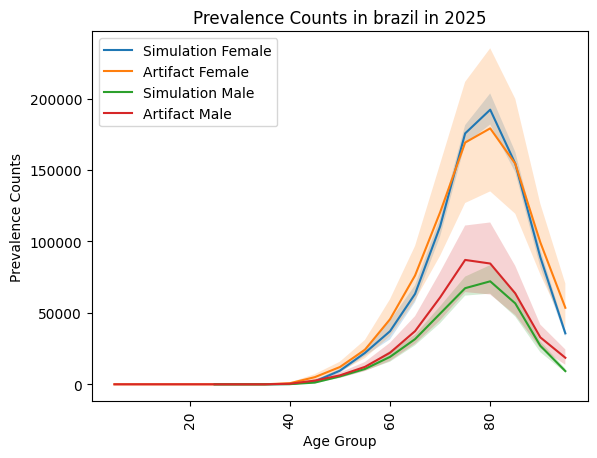

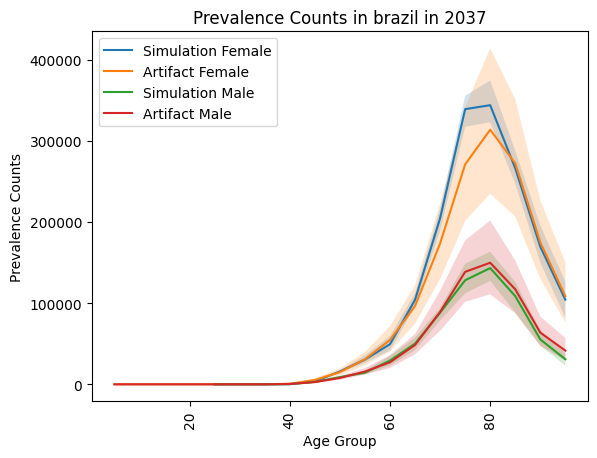

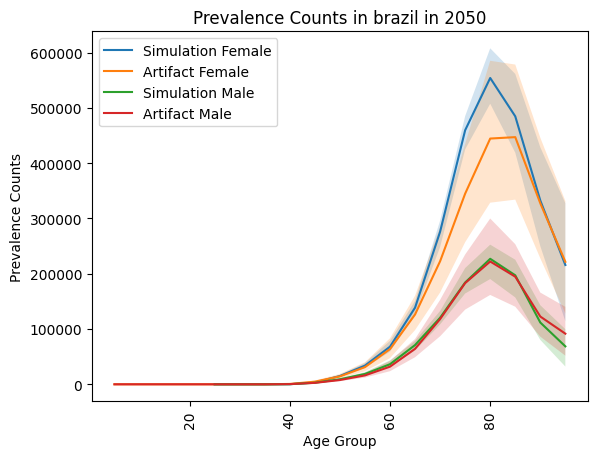

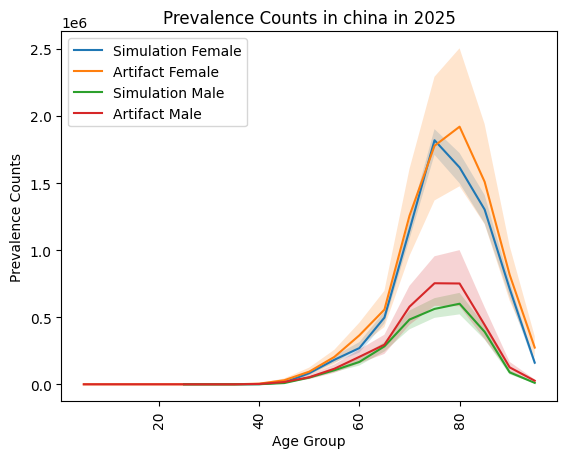

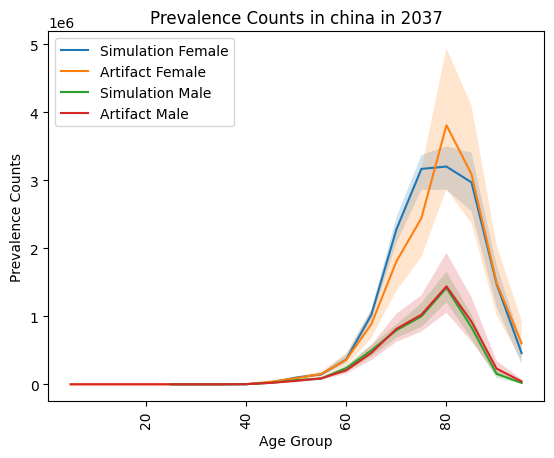

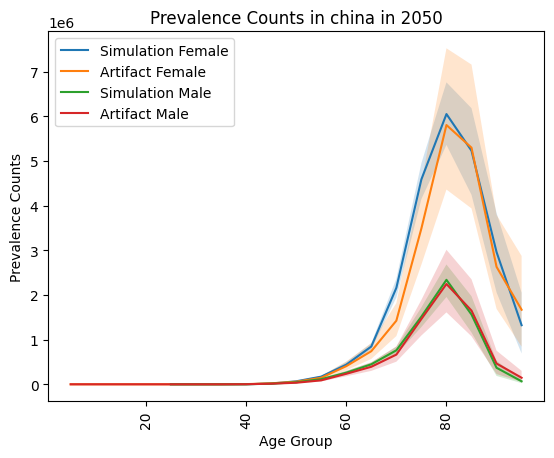

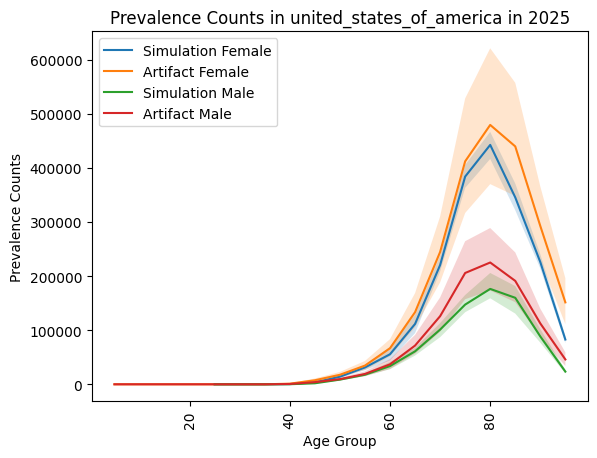

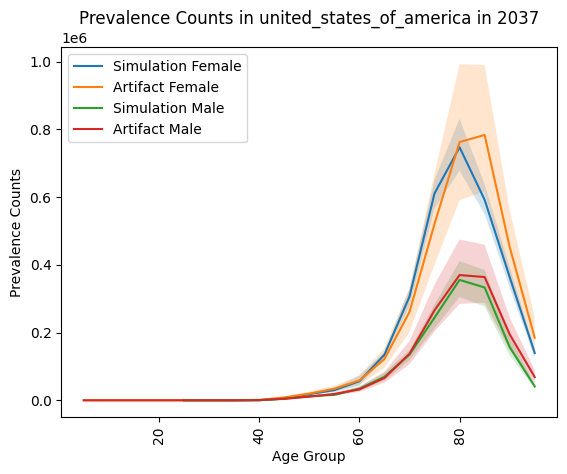

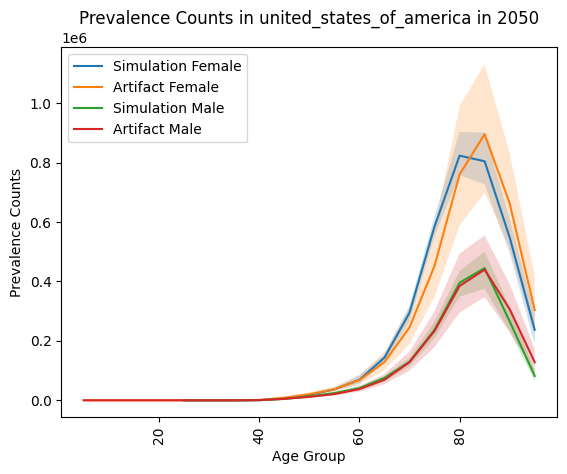

<Figure size 640x480 with 0 Axes>

In [73]:
for location in person_time_dementia.location.unique():
    for year in [2025,2037,2050]:
        for sex in person_time_dementia.sex.unique(): # [:1]:
            plot_data = person_time_dementia.loc[(person_time_dementia.location == location) & (person_time_dementia.event_year == year) & (person_time_dementia.sex == sex) ]
#             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace('_', ' ').title().replace('Of', 'of')
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot['mean'] = art_plot.filter(like='draw_').mean(axis=1)
            art_plot['upper'] = np.percentile(art_plot.filter(like='draw_'), 97.5, axis=1)
            art_plot['lower'] = np.percentile(art_plot.filter(like='draw_'), 2.5, axis=1)

            plt.plot(plot_data.age_start, plot_data['mean'], label=f'Simulation {sex}')
            plt.fill_between(plot_data.age_start, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)

            plt.plot(art_plot.age_start, art_plot['mean'], label=f'Artifact {sex}')
            plt.fill_between(art_plot.age_start, art_plot['upper'], art_plot['lower'], alpha=0.2)

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis='x', labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
        plt.figure()

## Total Sim Population Over Time

In [74]:
cols = ['input_draw','event_year','location', 'scenario'] #, 'age_group']

# # FIXME: Don't reload person-time
# person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
person_time_total = person_time.groupby(cols)['value'].sum().reset_index()
person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()
person_time_total.head()

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1365133097.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time.groupby(cols)['value'].sum().reset_index()
/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/1365133097.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby([c for c in cols if c != 'input_draw'])['value'].describe(percentiles=[0.025,0.975]).reset_index()


event_year                  location                    scenario  count  \
0        2022                    brazil                    baseline   25.0   
1        2022                    brazil  bbbm_testing_and_treatment   25.0   
2        2022                     china                    baseline   25.0   
3        2022                     china  bbbm_testing_and_treatment   25.0   
4        2022  united_states_of_america                    baseline   25.0   

            mean         std            min           2.5%            50%  \
0  101484.655003   69.772853  101352.449008  101376.665845  101482.502396   
1  101484.655003   69.772853  101352.449008  101376.665845  101482.502396   
2  101546.123915  142.392138  101238.340862  101277.805339  101574.187543   
3  101546.123915  142.392138  101238.340862  101277.805339  101574.187543   
4  101163.916441   86.002701  101017.100616  101020.090349  101170.573580   

           97.5%            max  
0  101625.710609  101649.927447  
1  101625.710609  101649.927447  
2  101816.256263  101857.215606  
3  101816.256263  101857.215606  
4  101311.489665  101337.500342

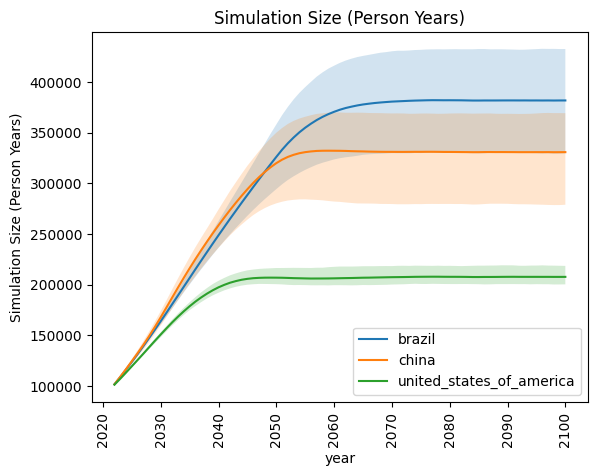

In [75]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[
        (person_time_total.location == location) & (person_time_total.scenario == scenario)]
    plt.plot(plot_data.event_year, plot_data['mean'], label=location)
    plt.fill_between(plot_data.event_year, plot_data['2.5%'], plot_data['97.5%'], alpha=0.2)
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis='x', labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()

# Decompose person-time by state

In [76]:
person_time

measure entity_type                                  entity  \
0        person_time       cause  alzheimers_disease_and_other_dementias   
1        person_time       cause  alzheimers_disease_and_other_dementias   
2        person_time       cause  alzheimers_disease_and_other_dementias   
3        person_time       cause  alzheimers_disease_and_other_dementias   
4        person_time       cause  alzheimers_disease_and_other_dementias   
...              ...         ...                                     ...   
6398995  person_time       cause  alzheimers_disease_and_other_dementias   
6398996  person_time       cause  alzheimers_disease_and_other_dementias   
6398997  person_time       cause  alzheimers_disease_and_other_dementias   
6398998  person_time       cause  alzheimers_disease_and_other_dementias   
6398999  person_time       cause  alzheimers_disease_and_other_dementias   

                                         sub_entity age_group  event_year  \
0            alzheimers_blood_based_biomarker_state  25_to_29        2022   
1            alzheimers_blood_based_biomarker_state  25_to_29        2022   
2            alzheimers_blood_based_biomarker_state  25_to_29        2022   
3            alzheimers_blood_based_biomarker_state  25_to_29        2022   
4            alzheimers_blood_based_biomarker_state  25_to_29        2022   
...                                             ...       ...         ...   
6398995  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398996  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398997  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398998  alzheimers_mild_cognitive_impairment_state   95_plus        2100   
6398999  alzheimers_mild_cognitive_impairment_state   95_plus        2100   

            sex                  treatment  \
0        Female  no_effect_after_treatment   
1        Female  no_effect_after_treatment   
2        Female  no_effect_after_treatment   
3        Female  no_effect_after_treatment   
4        Female  no_effect_after_treatment   
...         ...                        ...   
6398995    Male              waning_effect   
6398996    Male              waning_effect   
6398997    Male              waning_effect   
6398998    Male              waning_effect   
6398999    Male              waning_effect   

                                             artifact_path  \
0        /mnt/team/simulation_science/pub/models/vivari...   
1        /mnt/team/simulation_science/pub/models/vivari...   
2        /mnt/team/simulation_science/pub/models/vivari...   
3        /mnt/team/simulation_science/pub/models/vivari...   
4        /mnt/team/simulation_science/pub/models/vivari...   
...                                                    ...   
6398995  /mnt/team/simulation_science/pub/models/vivari...   
6398996  /mnt/team/simulation_science/pub/models/vivari...   
6398997  /mnt/team/simulation_science/pub/models/vivari...   
6398998  /mnt/team/simulation_science/pub/models/vivari...   
6398999  /mnt/team/simulation_science/pub/models/vivari...   

                           scenario input_draw     value  \
0                          baseline          1  0.000000   
1                          baseline          6  0.000000   
2                          baseline          7  0.000000   
3                          baseline         24  0.000000   
4                          baseline         35  0.000000   
...                             ...        ...       ...   
6398995  bbbm_testing_and_treatment        235  5.979466   
6398996  bbbm_testing_and_treatment        236  2.989733   
6398997  bbbm_testing_and_treatment        245  1.993155   
6398998  bbbm_testing_and_treatment        248  0.996578   
6398999  bbbm_testing_and_treatment        249  5.481177   

                         location  
0        united_states_of_america  
1        united_states_of_america  
2        united_states_of_america  
3        uni

In [77]:
cols = ["input_draw", "event_year", "sub_entity", "location", "scenario"]  # , 'age_group']

person_time_total = person_time.groupby(cols, observed=True)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

/var/folders/wx/h178pl2x4dn934yz5xnq0wfc0000gp/T/ipykernel_83969/2789164734.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]


event_year                                  sub_entity  \
0           2022      alzheimers_blood_based_biomarker_state   
1           2022      alzheimers_blood_based_biomarker_state   
2           2022      alzheimers_blood_based_biomarker_state   
3           2022      alzheimers_blood_based_biomarker_state   
4           2022      alzheimers_blood_based_biomarker_state   
...          ...                                         ...   
1417        2100  alzheimers_mild_cognitive_impairment_state   
1418        2100  alzheimers_mild_cognitive_impairment_state   
1419        2100  alzheimers_mild_cognitive_impairment_state   
1420        2100  alzheimers_mild_cognitive_impairment_state   
1421        2100  alzheimers_mild_cognitive_impairment_state   

                      location                    scenario  count  \
0                       brazil                    baseline   25.0   
1                       brazil  bbbm_testing_and_treatment   25.0   
2                        china                    baseline   25.0   
3                        china  bbbm_testing_and_treatment   25.0   
4     united_states_of_america                    baseline   25.0   
...                        ...                         ...    ...   
1417                    brazil  bbbm_testing_and_treatment   25.0   
1418                     china                    baseline   25.0   
1419                     china  bbbm_testing_and_treatment   25.0   
1420  united_states_of_america                    baseline   25.0   
1421  united_states_of_america  bbbm_testing_and_treatment   25.0   

              mean          std           min          2.5%           50%  \
0     47154.289062   259.430258  46529.713895  46649.303217  47212.867899   
1     47154.289062   259.430258  46529.713895  46649.303217  47212.867899   
2     48381.395099   336.539397  47795.865845  47818.288843  48320.563997   
3     48381.395099   336.539397  47795.865845  47818.288843  48320.563997   
4     47068.722902   161.856811  46796.796715  46810.250513  47084.309377   
...            ...          ...           ...           ...           ...   
1417  77003.983244  6368.647072  63221.891855  65461.799863  78268.221766   
1418  71382.009473  6393.284052  57141.273101  59757.887474  72131.794661   
1419  68786.941109  6427.155839  54117.656400  56769.250650  70335.463381   
1420  43942.418836  1288.358566  42366.012320  42411.157290  43779.159480   
1421  42365.454237  1238.130987  40578.151951  40712.689938  42229.481177   

             97.5%           max  
0     47453.740726  47474.967830  
1     47453.740726  47474.967830  
2     48928.875017  48986.277892  
3     48928.875017  48986.277892  
4     47329.467488  47333.952088  
...            ...           ...  
1417  87677.908282  89077.103354  
1418  80794.346886  81958.548939  
1419  78313.865024  79019.143053  
1420  46702.420808  47806.828200  
1421  45030.861054  45900.873374  

[1422 rows x 12 columns]

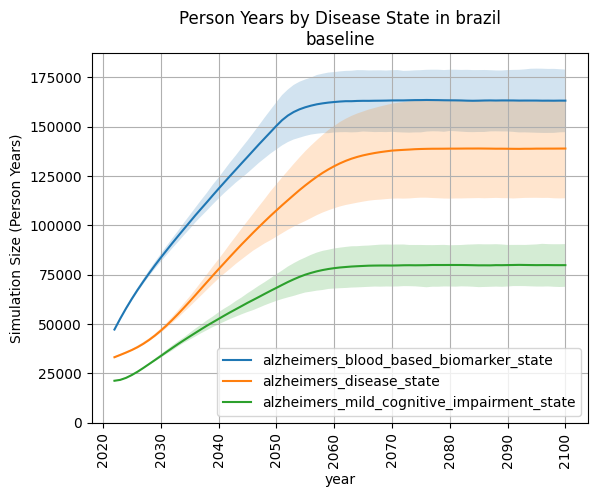

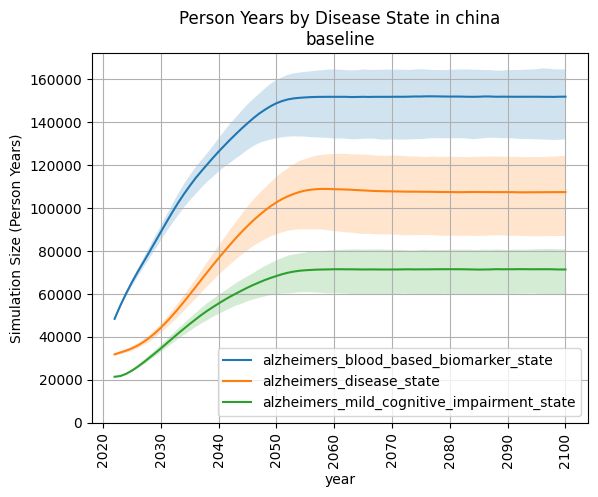

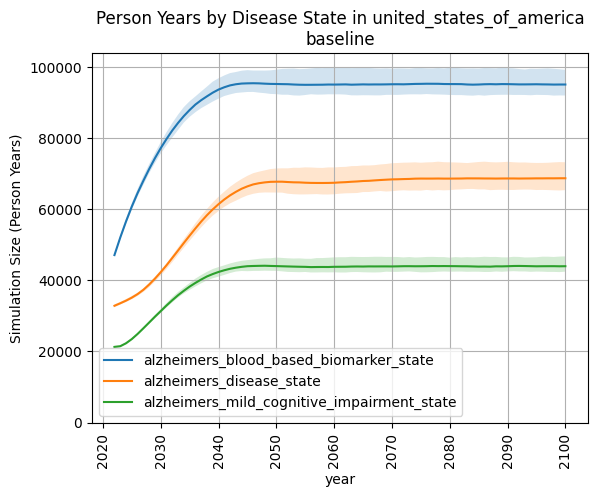

<Figure size 640x480 with 0 Axes>

In [78]:
scenario = 'baseline'
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity and scenario == @scenario"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}\n{scenario}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()
    plt.figure()

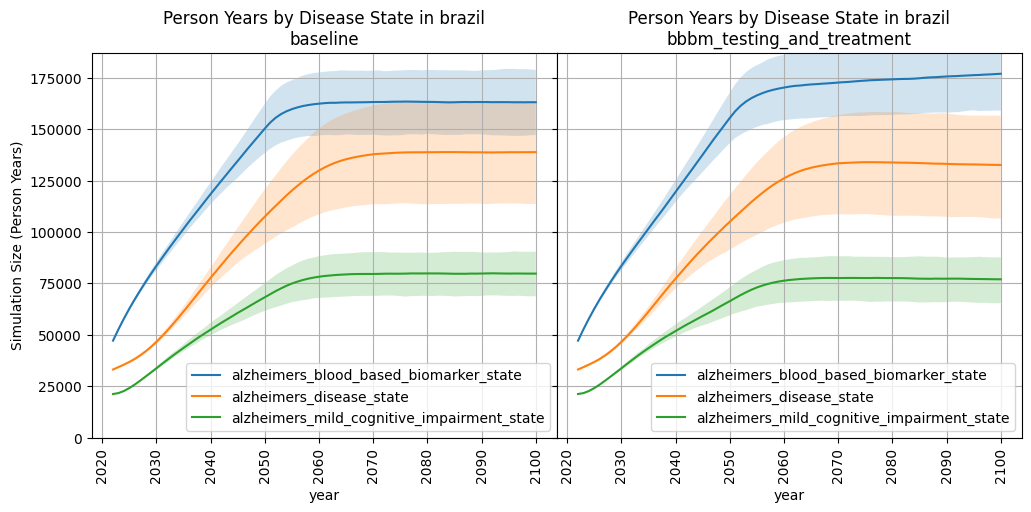

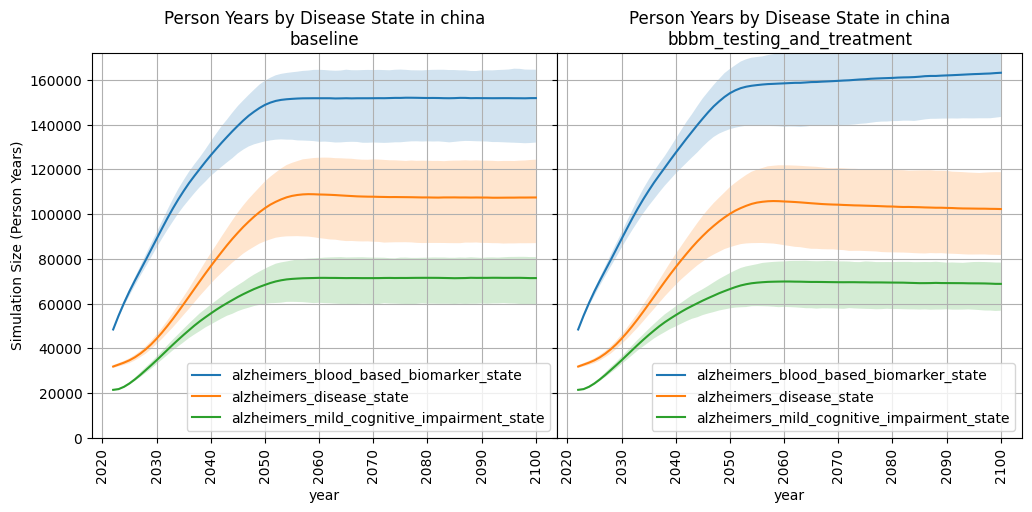

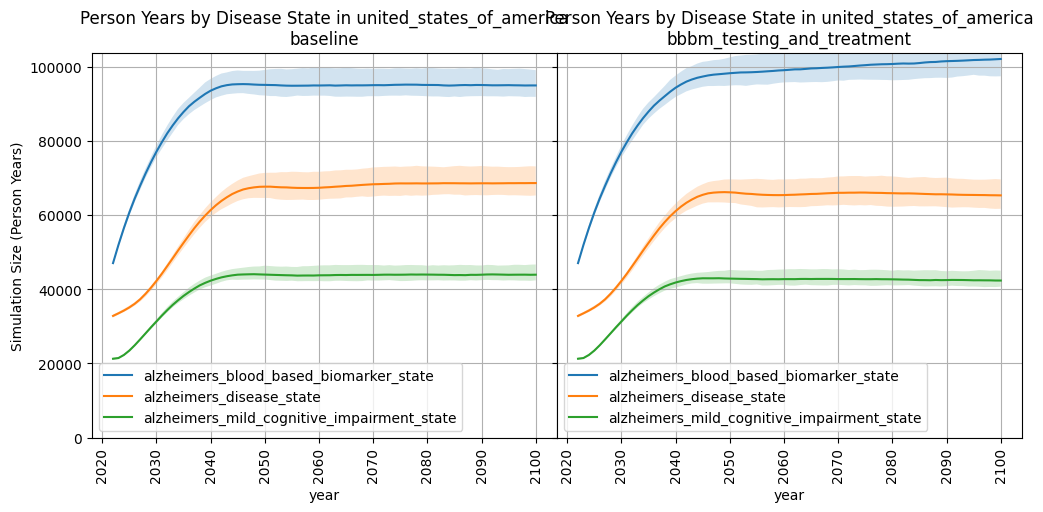

In [79]:
for location in person_time_total.location.unique():
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0)
    for scenario, ax in zip (['baseline', 'bbbm_testing_and_treatment'], axs):
        for sub_entity in person_time_total.sub_entity.unique():
            plot_data = person_time_total.query(
                "location == @location and sub_entity == @sub_entity and scenario == @scenario"
            )
            ax.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
            ax.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )
        ax.set_title(f"Person Years by Disease State in {location}\n{scenario}")
        ax.tick_params(axis="x", labelrotation=90)
        ax.set_xlabel("year")
        if scenario == 'baseline':
            ax.set_ylabel("Simulation Size (Person Years)")
        ax.legend()
        ax.axis(ymin=0)
        ax.grid()

plt.show()

In [80]:
!date

Wed Feb  4 16:44:42 PST 2026
